# 1. Set-up

In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import random
from collections import Counter
import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 30})
import pandas as pd
import numpy as np
import scipy.interpolate
from scipy.interpolate import interp1d
from src.utils.Notebook_imports import *
from src.data.Preprocess import clip_quantile
from src.data.Dataset import load_phase_reg_exp
from src.visualization.Visualize import plot_dir_norm
from src.visualization.Visualize import show_2D_or_3D
from src.models.predict_phase_reg_model import predict_phase_from_deformable

import tensorflow as tf
from src.models.KerasLayers import get_angle_tf,get_focus_tf,get_idxs_tf, minmax_lambda, flow2direction_lambda
# define some central params
lower, mid, upper = -1,0, 1
phases = ['ED', 'MS', 'ES', 'PF', 'MD']

from ipywidgets import interact
import ipywidgets as widgets
from IPython.core.display import display, HTML
%matplotlib inline
%reload_ext autoreload
%autoreload 2

search for root_dir and set working directory
Working directory set to: /mnt/ssd/sarah/git/cmr-phase2phase-las-analysis


/tmp/ipykernel_223801/2156998001.py:31: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Notebook_imports import *
import numpy as np
import SimpleITK as sitk 
import pandas as pd
import csv

search for root_dir and set working directory
Working directory set to: /mnt/ssd/sarah/git/cmr-phase2phase-las-analysis


In [6]:
from ipyfilechooser import FileChooser
def get_file(path):
    files = sorted(glob.glob(path))
    print(f"Found {len(files)} in {path}")
    return files

## 1.1 Get experiments folder
Select folder with trained registration model

In [4]:
path_chooser = FileChooser(os.path.join(os.getcwd(),''), '')
display(path_chooser)

FileChooser(path='/mnt/ssd/sarah/git/cmr-phase2phase-las-analysis', filename='', title='', show_hidden=False, …

In [8]:
model_path = path_chooser.selected
cfd_path = get_file(os.path.join(model_path, 'cfd.csv'))
gt_path = get_file(os.path.join(model_path, 'gt_phases.csv'))
pred_path = get_file(os.path.join(model_path, 'pred_phases.csv'))

gt_df = pd.read_csv(gt_path[0])
cfd_df = pd.read_csv(cfd_path[0])
pred_df = pd.read_csv(pred_path[0])
print(f"\nSelected path to model: {model_path}")

Found 1 in /mnt/ssd/sarah/git/cmr-phase2phase-las-analysis/exp/mnms2/fimh/2025-09-01_17_03/cfd.csv
Found 1 in /mnt/ssd/sarah/git/cmr-phase2phase-las-analysis/exp/mnms2/fimh/2025-09-01_17_03/gt_phases.csv
Found 1 in /mnt/ssd/sarah/git/cmr-phase2phase-las-analysis/exp/mnms2/fimh/2025-09-01_17_03/pred_phases.csv

Selected path to model: /mnt/ssd/sarah/git/cmr-phase2phase-las-analysis/exp/mnms2/fimh/2025-09-01_17_03/


## 1.2 Get data folder (with segmentation masks)
Select folder with subfolder "lax" containing CMR + maskfiles

In [9]:
data_path_chooser = FileChooser(os.path.join(os.getcwd(),''), '')
display(data_path_chooser)

FileChooser(path='/mnt/ssd/sarah/git/cmr-phase2phase-las-analysis', filename='', title='', show_hidden=False, …

In [11]:
data_path = data_path_chooser.selected
masks_path = get_file(os.path.join(data_path, 'lax/*_masks.nii.gz'))
img_path = get_file(os.path.join(data_path, 'lax/*CINE.nii.gz'))
dataset_info_path = get_file(os.path.join(data_path, 'dataset_information.csv'))

dataset_df = pd.read_csv(dataset_info_path[0])
print(dataset_df)
print(f"Number of images: {len(img_path)}\nNumber of masks: {len(masks_path)}")

Found 160 in /mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/lax/*_masks.nii.gz
Found 160 in /mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/lax/*CINE.nii.gz
Found 1 in /mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/dataset_information.csv
     SUBJECT_CODE DISEASE                   VENDOR      SCANNER  FIELD
0             201     NOR                  SIEMENS  SymphonyTim    1.5
1             202     NOR                  SIEMENS  SymphonyTim    1.5
2             203     NOR  Philips Medical Systems      Achieva    1.5
3             204     NOR  Philips Medical Systems      Achieva    1.5
4             205     NOR  Philips Medical Systems      Achieva    1.5
..            ...     ...                      ...          ...    ...
155           356     TRI                  SIEMENS     Symphony    1.5
156           357     TRI                  SIEMENS  SymphonyTim    1.5
157           358     TRI                  SIEMENS     Symphony    1.5
158           359     

In [12]:
dataset_df['DISEASE'] = dataset_df['DISEASE'].apply(lambda x: f"D{x}" if x in ["LV", "RV"] else x)

## 1.2 Functions

In [13]:
def measure_length(apex_point, base_point):
    distance = np.linalg.norm(np.array(apex_point) - np.array(base_point))
    return distance

def measure_length_mm(apex_point, base_point, spacing_x, spacing_y):
    # Convert pixel coordinates to real-world coordinates by multiplying with the spacings
    real_apex = (apex_point[0] * spacing_x, apex_point[1] * spacing_y)
    real_base = (base_point[0] * spacing_x, base_point[1] * spacing_y)
    
    # Calculate the distance between these real-world coordinates
    distance = np.linalg.norm(np.array(real_apex) - np.array(real_base))
    return distance

In [14]:
def load_mask(path):
    sitk_mask = sitk.ReadImage(path)
    mask = sitk.GetArrayFromImage(sitk_mask)
    return mask

def get_k_masks(path, phases):
    k_masks = []
    mask = load_mask(path)
    for phase in phases:
        k_masks.append(mask[phase,...])
    return k_masks

In [15]:
def calculate_long_axis_strain(length_list, phases = ['ED', 'MS', 'ES', 'PF', 'MD']):
    #phase_to_length = {phase: L for L, phase in zip(length_list, phases)}
    #desired_order = ['ED', 'MS', 'ES', 'PF', 'MD']
    #phase_to_length = {phase: phase_to_length[phase] for phase in desired_order}
    #length_list = [phase_to_length[phase] for phase in desired_order]
    
    ed2k = get_ed2k_las(length_list)
    k2k = get_k2k_las(length_list)
    return ed2k, k2k

def get_ed2k_las(lens):
    ed_len = lens[0]
    ed2k =  [(L - ed_len) * 100 / ed_len for L in lens]
    return ed2k

def get_k2k_las(lens):
   # Calculate long axis strain between frames (L(t)-L(t-1))/L(t-1)
    k2k_las = []
    for i in range(0, len(lens)):
        k2k_las.append((lens[i] - lens[i - 1]) * 100 / lens[i - 1])
    return k2k_las

In [16]:
import cv2
def split_myo_mask(myo_mask):
    structure = np.ones((3, 3))  
    eroded_mask = ndimage.binary_erosion(myo_mask, structure=structure)
    return eroded_mask

In [17]:
def remove_small_components(mask, myo=False, min_size=50):
    """Remove small connected components from a binary mask."""
    mask_copy = mask 
    if myo:
        mask = ndimage.binary_dilation(mask, structure=np.ones((2, 2)))
        mask = fill_myo_gaps(mask, ).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    # Find the largest component (excluding background)
    largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Skip background (0)

    # Create a new mask with only the largest component
    clean_mask = np.zeros_like(mask)
    clean_mask[labels == largest_component] = 1
    clean_mask = clean_mask & mask_copy
    return clean_mask


In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from itertools import combinations
from scipy.spatial import distance

def fill_myo_gaps(myo_mask, structure_size=8):
    """Fill small gaps in the myocardium mask."""
    structure = np.ones((structure_size, structure_size))
    filled_mask = ndimage.binary_closing(myo_mask, structure=structure)
    return filled_mask


def find_lvip(myo_mask, lv_mask, structure, dil=True):
    grown_myo_mask = ndimage.binary_dilation(myo_mask, structure=structure)
    grown_myo_mask = fill_myo_gaps(grown_myo_mask)  # Fill myocardium gaps before proceeding
    myo_points = np.array(np.where(myo_mask ==1)).T
    
    lv_boundary = ndimage.binary_dilation(lv_mask, structure=structure) - lv_mask
    grown_myo_boundary = ndimage.binary_dilation(grown_myo_mask, structure=structure) ^ grown_myo_mask
    potential_lvip_points = np.array(np.where((lv_boundary == 1) & (grown_myo_boundary == 1))).T
    if len(potential_lvip_points) > 0 and len(myo_points) > 0:
        potential_lvip_points = np.array([myo_points[np.argmin(distance.cdist([p], myo_points))] for p in potential_lvip_points]).T
        potential_lvip_points = np.unique(potential_lvip_points, axis=1)
    return lv_boundary, grown_myo_boundary, potential_lvip_points
    

def filter_and_select_lvip(lv_ip_points):
    unique_points = []
    seen_coords = set()
    for point in lv_ip_points:
        x_coord = point[0]
        y_coord = point[1]
        if x_coord not in seen_coords and y_coord not in seen_coords:
            unique_points.append(point)
            seen_coords.add(x_coord)
            seen_coords.add(y_coord)
    # print(f"{len(lv_ip_points)} selected points: {lv_ip_points}")
    if len(unique_points) < 2:
        return lv_ip_points
    
    # print(f"{len(unique_points)} unique points: {unique_points}")
    min_distance = float('inf')
    closest_pair = None
    for p1, p2 in combinations(unique_points, 2):
        dist = np.linalg.norm(np.array(p1) - np.array(p2))
        if dist < min_distance and dist > 15: #15:
            min_distance = dist
            closest_pair = (p1, p2)
    # print(f"{closest_pair}")
    if closest_pair is None:
        return lv_ip_points
    return closest_pair

In [19]:
def get_LV_landmarks_grow2(lv_mask, myo_mask, mask, plot=True, epi_mid=True, endo_mid=False):
    structure = np.ones((4, 4))
    lv_boundary, myo_boundary, potential_lvip_points = find_lvip(myo_mask, lv_mask, structure)
    if len(potential_lvip_points) == 0:
        myo_mask = split_myo_mask(myo_mask)    
        lv_boundary, myo_boundary, potential_lvip_points= find_lvip(myo_mask, lv_mask, structure, dil=False)
        if len(potential_lvip_points[0]) == 0:
            print("No potential LVIP points detected in grown mask after gap filling.")
            return None

    lv_contour_points = np.array(np.where(lv_boundary == 1)).T
    selected_lvip_points = []

    for potential_point in zip(potential_lvip_points[0], potential_lvip_points[1]):
        distances = np.sqrt((lv_contour_points[:, 0] - potential_point[0])**2 + 
                            (lv_contour_points[:, 1] - potential_point[1])**2)
        closest_idx = np.argmin(distances)
        selected_lvip_points.append(tuple(lv_contour_points[closest_idx]))
    selected_lvip_points = filter_and_select_lvip(selected_lvip_points)

    if len(selected_lvip_points) >= 2:
        lvip_1, lvip_2 = selected_lvip_points[0], selected_lvip_points[-1]
        map_point = ((lvip_1[0] + lvip_2[0]) // 2, (lvip_1[1] + lvip_2[1]) // 2)
    else:
        print("Not enough LVIP points found.")
        return None

    
    # Step 4: Find the Apex Point at the Endocardium (farthest from MAP)
    structure = np.ones((2, 2))
    myo_inner_boundary = myo_mask ^ ndimage.binary_erosion(myo_mask, structure=structure)
    if endo_mid:
        endocardium_points = np.where((myo_inner_boundary == 1) & (ndimage.binary_dilation(lv_mask, structure=structure) == 1))
        myo_contour = endocardium_points
    if epi_mid:
        epicardium_points = np.where((myo_inner_boundary == 1) ^ (ndimage.binary_dilation(lv_mask, structure=structure) == 1))
        myo_contour = epicardium_points
    
    if map_point and len(myo_contour[0]) > 0:
        distances = np.sqrt((myo_contour[0] - map_point[0])**2 + 
                            (myo_contour[1] - map_point[1])**2)
        distances_to_lvip_1 = np.sqrt((myo_contour[0] - lvip_1[0])**2 + (myo_contour[1] - lvip_1[1])**2) # orig excl.
        distances_to_lvip_2 = np.sqrt((myo_contour[0] - lvip_2[0])**2 + (myo_contour[1] - lvip_2[1])**2) # orig excl.
    
        combined_distances = distances_to_lvip_1 + distances_to_lvip_2 + distances # orig excl.
    
        furthest_myo_contour_idx = np.argmax(combined_distances)
        # furthest_myo_contour_idx = np.argmax(distances)
        
        apex_point = (myo_contour[0][furthest_myo_contour_idx], 
                      myo_contour[1][furthest_myo_contour_idx])
    else:
        print("Apex point could not be calculated.")
        apex_point = None

    # Step 5: Plot the results
    if plot:
        plt.imshow(mask, cmap='gray')
        if potential_lvip_points[0].size > 0:
            plt.scatter(potential_lvip_points[1], potential_lvip_points[0], color='yellow', label='Potential LVIP Points')  # Yellow points
        if lvip_1 and lvip_2:
            plt.scatter([lvip_1[1], lvip_2[1]], [lvip_1[0], lvip_2[0]], color='red', label='Selected LVIP Points')  # Red points
        if map_point:
            plt.scatter(map_point[1], map_point[0], color='green', label='Mitral Annulus Point')  # Green point
        if apex_point:
            plt.scatter(apex_point[1], apex_point[0], color='blue', label='Apex Point at Endocardium')  # Blue point
        plt.title('LVIP, MAP, and Apex Point at Endocardium')
        plt.legend()
        plt.show()

    return {
        "apex_point": apex_point,
        "mitral_annulus_points": (lvip_1, lvip_2) if len(selected_lvip_points) >= 2 else None,
        "mitral_annulus_midpoint": map_point
    }



In [20]:
# Functions to track the point motion (currently not in use)
def track_point_motion(point_coords, frame_size, max_movement_ratio=0.1):
    """Check if point coordinates move within allowed limits across frames."""
    max_movement = frame_size * max_movement_ratio
    
    for i in range(1, len(point_coords)):
        dist = np.linalg.norm(np.array(point_coords[i]) - np.array(point_coords[i - 1]))
        if dist > max_movement:
            return False
    
    return True


def validate_landmarks_across_frames(point_coords, frame_size, max_movement_ratio=0.1):
    if not track_point_motion(point_coords, frame_size, max_movement_ratio):
        print("Warning: Point positions move too much between frames!")
        return False
    return True



# 1.2.2 Test functions

/mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/lax/329_LA_CINE_masks.nii.gz


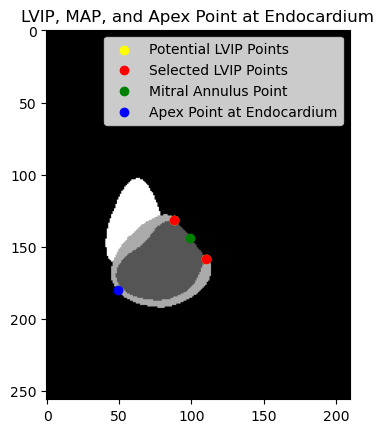

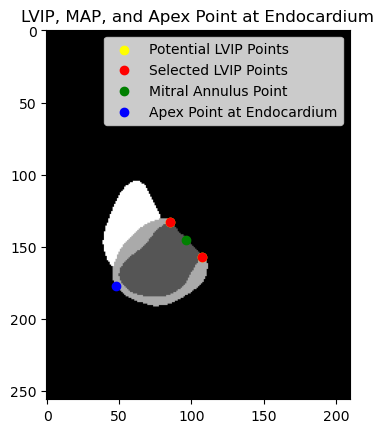

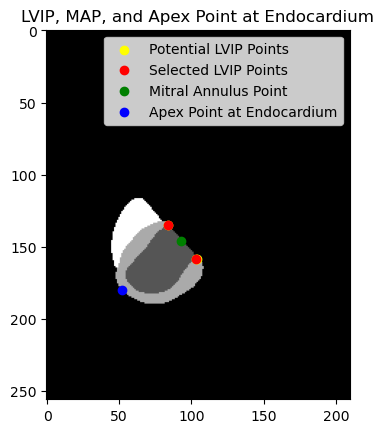

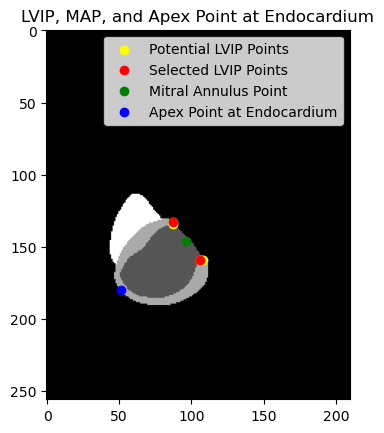

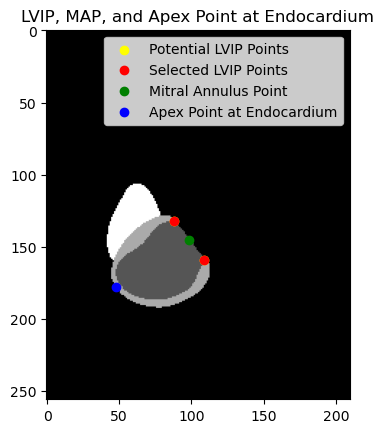

In [21]:
# Calculate ed2k and k2k for each patient in masks path
plot = True
results = []
test_idx = [128] #[1, 37, 11, 43]
for idx, file in enumerate(masks_path):
    if idx not in test_idx:
        continue
    print(file)
    long_axis_lens = []
    msk_points = []
    k_masks = get_k_masks(file, pred_df[phases].iloc[idx])

    for idx_m, mask in enumerate(k_masks):
        mask = mask[0, ...]
        lv_mask = (mask == 1).astype(np.uint8)
        # lv_mask = remove_small_components(lv_mask)
        myo_mask = (mask == 2).astype(np.uint8)
        # myo_mask =remove_small_components(myo_mask, myo = True)
    
        # Use the updated function with the new options
        points = get_LV_landmarks_grow2(
            lv_mask, 
            myo_mask, 
            mask, 
            plot=plot, 
            epi_mid=True, 
            endo_mid=False
        )

        msk_points.append(points)

        if points is not None:
            long_axis_lens.append(measure_length(points['apex_point'], points['mitral_annulus_midpoint']))
        else:
            print(f" No results for {file} (ID here: {idx})\n For the mask of: {this_phases[idx_m]}")
            long_axis_lens.append(-1)


# 2. Calculate Long-Axis Strain (LAS)

In [22]:
# Initialize
gt_phases = pd.read_csv(gt_path[0])
this_phases = [phase for phase in gt_phases.columns.tolist() if len(phase)==2]


In [26]:
# Calculate ed2k and k2k for each patient in masks path
plot = False
results = []
phases = this_phases

# exclude_patients = [211, 213, 229, 233, 237, 240, 244, 249, 259, 272, 284, 303, 305, 331, 335, 345, 348, 349]
exclude_patients = []
exclude_found_patient = []

for idx, file in enumerate(masks_path):
    long_axis_lens = []
    msk_points = []
    k_masks = get_k_masks(file, pred_df[phases].iloc[idx])
    patient_file = file.split("/")[-1]
    if any([str(x) in patient_file for x in exclude_patients]):
        print(f"Skip patient_file: {patient_file}")
        exclude_found_patient.append(idx)
        continue
    for idx_m, mask in enumerate(k_masks):
        mask = mask[0, ...]
        lv_mask = (mask == 1).astype(np.uint8)
        # lv_mask = remove_small_components(lv_mask)
        myo_mask = (mask == 2).astype(np.uint8)
        # myo_mask =remove_small_components(myo_mask, myo = True)
    
        # Use the updated function with the new options
        points = get_LV_landmarks_grow2(
            lv_mask, 
            myo_mask, 
            mask, 
            plot=plot, 
            epi_mid=True, 
            endo_mid=False
        )

        msk_points.append(points)

        if points is not None:
            long_axis_lens.append(measure_length(points['apex_point'], points['mitral_annulus_midpoint']))
        else:
            print(f" No results for {file} (ID here: {idx})\n For the mask of: {this_phases[idx_m]}")
            long_axis_lens.append(-1)

    ed2k, k2k = calculate_long_axis_strain(long_axis_lens, this_phases)

    results.append({
        "patient": patient_file ,
        "ed2k": ed2k,
        "k2k": k2k,
        "long-axis L": long_axis_lens,
        "point_coord": msk_points,
        "gt":pred_df[phases].iloc[idx]
    })

results_df = pd.DataFrame(results)

In [27]:
ed2k_array = np.zeros((len(results_df), 5))
k2k_array = np.zeros((len(results_df), 5))

for i, row in results_df.iterrows():
    ed2k_array[i] = np.array(row["ed2k"])  
    k2k_array[i] = np.array(row["k2k"]) 


In [30]:
print(f"Processed patients: {len(ed2k_array)}")
print(f"Skipped patient IDs: {exclude_found_patient}")
results_df

Processed patients: 160
Skipped patient IDs: []


,patient,ed2k,k2k,long-axis L,point_coord,gt
0,201_LA_CINE_masks.nii.gz,"[0.0, -8.659609638470293, -14.920949392181655,...","[1.2234949551158498, -8.659609638470293, -6.85...","[77.41446893184762, 70.71067811865476, 65.8634...","[{'apex_point': (143, 177), 'mitral_annulus_po...",ED 24 MS 5 ES 9 PF 12 MD 22 N...
1,202_LA_CINE_masks.nii.gz,"[0.0, -3.377802464424485, -17.877220313750787,...","[2.628414266928799, -3.377802464424485, -15.00...","[81.39410298049853, 78.64477096412705, 66.8430...","[{'apex_point': (181, 61), 'mitral_annulus_poi...",ED 24 MS 2 ES 9 PF 13 MD 22 N...
2,203_LA_CINE_masks.nii.gz,"[0.0, -7.552597128587234, -20.61439818830755, ...","[3.0823701658123484, -7.552597128587234, -14.1...","[73.81734213584231, 68.24221567329127, 58.6003...","[{'apex_point': (161, 179), 'mitral_annulus_po...",ED 0 MS 3 ES 7 PF 10 MD 17 N...
3,204_LA_CINE_masks.nii.gz,"[0.0, -9.538719125817885, -20.100655553446337,...","[5.428641512225034, -9.538719125817885, -11.67...","[75.76938695805846, 68.54195795277518, 60.5392...","[{'apex_point': (188, 76), 'mitral_annulus_poi...",ED 23 MS 4 ES 8 PF 13 MD 20 N...
4,205_LA_CINE_masks.nii.gz,"[0.0, -4.382342182594283, -26.220516658340838,...","[6.8529392520772054, -4.382342182594283, -22.8...","[68.81860213634101, 65.80273550544841, 50.7740...","[{'apex_point': (185, 105), 'mitral_annulus_po...",ED 19 MS 2 ES 9 PF 12 MD 15 N...
...,...,...,...,...,...,...
155,356_LA_CINE_masks.nii.gz,"[0.0, -2.6858738679944048, -12.45941277714724,...","[4.348093371004787, -2.6858738679944048, -10.0...","[57.62811813689564, 56.08029957123981, 50.4479...","[{'apex_point': (192, 114), 'mitral_annulus_po...",ED 24 MS 4 ES 9 PF 14 MD 19 N...
156,357_LA_CINE_masks.nii.gz,"[0.0, -4.285448254215335, -7.664318902729378, ...","[0.5004978014689099, -4.285448254215335, -3.53...","[65.7875368135941, 62.96824596572466, 60.74537...","[{'apex_point': (217, 86), 'mitral_annulus_poi...",ED 4 MS 9 ES 16 PF 20 MD 2 N...
157,358_LA_CINE_masks.nii.gz,"[0.0, -12.174973418064685, -27.23931248910011,...","[8.629801801712752, -12.174973418064685, -17.1...","[52.15361924162119, 45.803929962395145, 37.947...","[{'apex_point': (184, 66), 'mitral_annulus_poi...",ED 1 MS 5 ES 12 PF 16 MD 20 N...
158,359_LA_CINE_masks.nii.gz,"[0.0, 3.192289676354454, -10.884223497622923, ...","[3.891604942826191, 3.192289676354454, -13.641...","[68.00735254367721, 70.178344238091, 60.605280...","[{'apex_point': (158, 94), 'mitral_annulus_poi...",ED 23 MS 3 ES 10 PF 16 MD 19 N...


## 2.1 Visualize LAS curves for whole cohort
Mean & Median per pathology for the whole cohort

In [31]:
def plot_avg_curves(avg_ed2k, avg_k2k, avg_ed2k_per_pathology, avg_k2k_per_pathology, unique_pathology, avg="Mean"):
    plt.rcParams.update({
        'font.size': 14,       # Base font size
        'axes.titlesize': 28,  # Title font size
        'axes.labelsize': 28,  # Axis label font size
        'xtick.labelsize': 16, # X-tick label font size
        'ytick.labelsize': 16, # Y-tick label font size
        'legend.fontsize': 15  # Legend font size
    })

    # Plot the avg curves for ed2k
    plt.figure(figsize=(10, 6))
    for pathology, avg_ed2k in zip(unique_pathologies, avg_ed2k_per_pathology):
        plt.plot(this_phases+['ED*'], np.append(avg_ed2k, avg_ed2k[0]), label=pathology)
    plt.xlabel('Phase')
    plt.ylabel('Long axis strain [%]')
    plt.legend()
    plt.xlim([0, len(phases)])
    plt.title(f'{avg} ED2K LAS per pathology')
    plt.grid()
    plt.show()


    # Plot the avg curves for k2k
    plt.figure(figsize=(10, 6))
    for pathology, avg_k2k in zip(unique_pathologies, avg_k2k_per_pathology):
        plt.plot(this_phases+['ED*'], np.append(avg_k2k, avg_k2k[0]), label=pathology)
    plt.xlabel('Phase')
    plt.ylabel('Long axis strain [%]')
    plt.legend()
    plt.xlim([0, len(phases)])
    plt.title(f'{avg} K2K LAS per pathology')
    plt.grid()
    plt.show()

In [35]:
# Calculate mean ed2k and k2k per pathology
mean_ed2k_per_pathology = []
mean_k2k_per_pathology = []
median_ed2k_per_pathology = []
median_k2k_per_pathology = []

unique_pathologies = dataset_df['DISEASE'].unique()
valid_patients = ~dataset_df.index.isin(exclude_found_patient)

filtered_df = dataset_df[valid_patients].reset_index(drop=True)

for pathology in unique_pathologies:
    pathology_indices = filtered_df['DISEASE'] == pathology
    mean_ed2k_per_pathology.append(np.mean(ed2k_array[pathology_indices], axis=0))
    mean_k2k_per_pathology.append(np.mean(k2k_array[pathology_indices], axis=0))

    
    median_ed2k_per_pathology.append(np.median(ed2k_array[pathology_indices], axis=0))
    median_k2k_per_pathology.append(np.median(k2k_array[pathology_indices], axis=0))

    
mean_ed2k_array = np.stack(mean_ed2k_per_pathology, axis=0)
mean_k2k_array = np.stack(mean_k2k_per_pathology, axis=0)
median_ed2k_array = np.stack(median_ed2k_per_pathology, axis=0)
median_k2k_array = np.stack(median_k2k_per_pathology, axis=0)

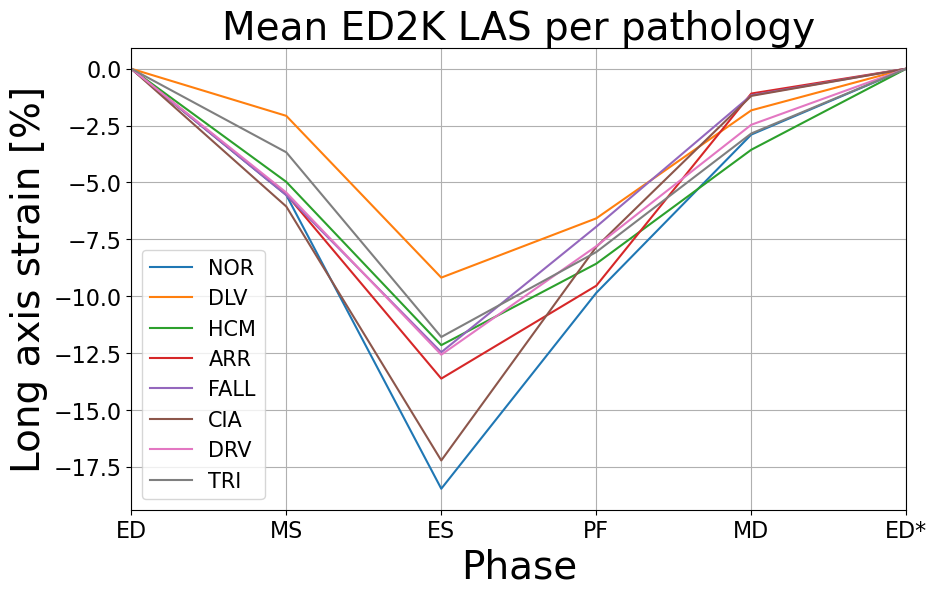

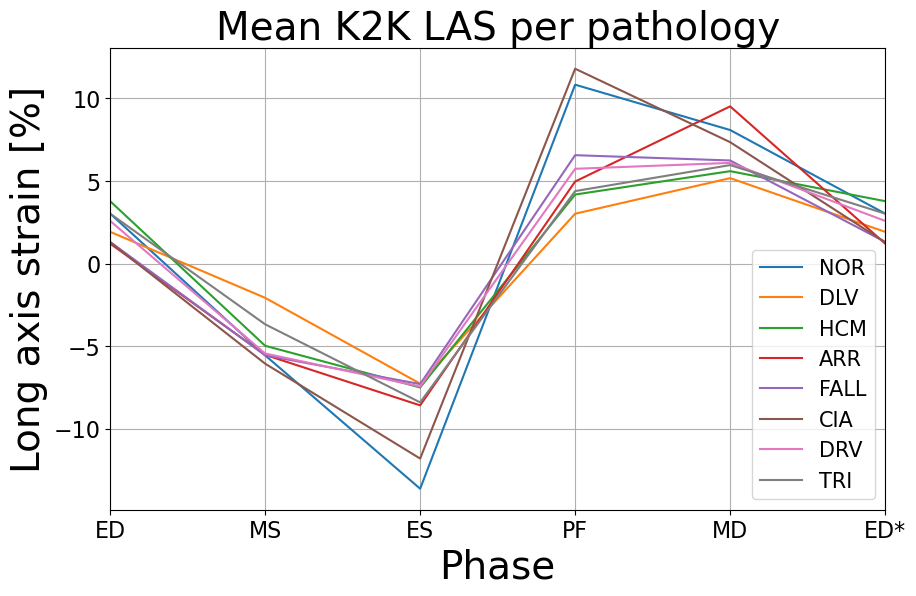

In [36]:
# Plot Mean
plot_avg_curves(mean_ed2k_array, mean_k2k_array, mean_ed2k_per_pathology, mean_k2k_per_pathology, unique_pathologies)

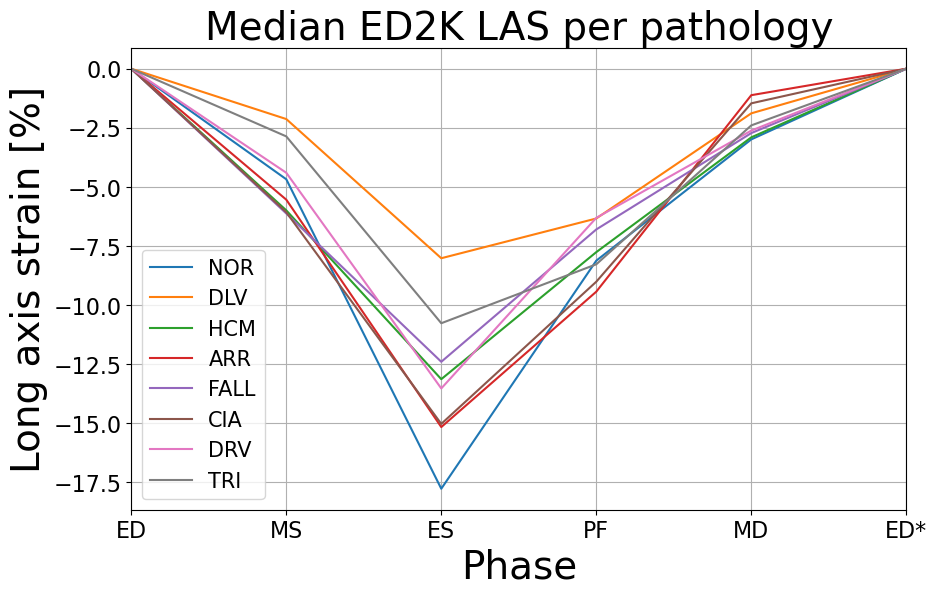

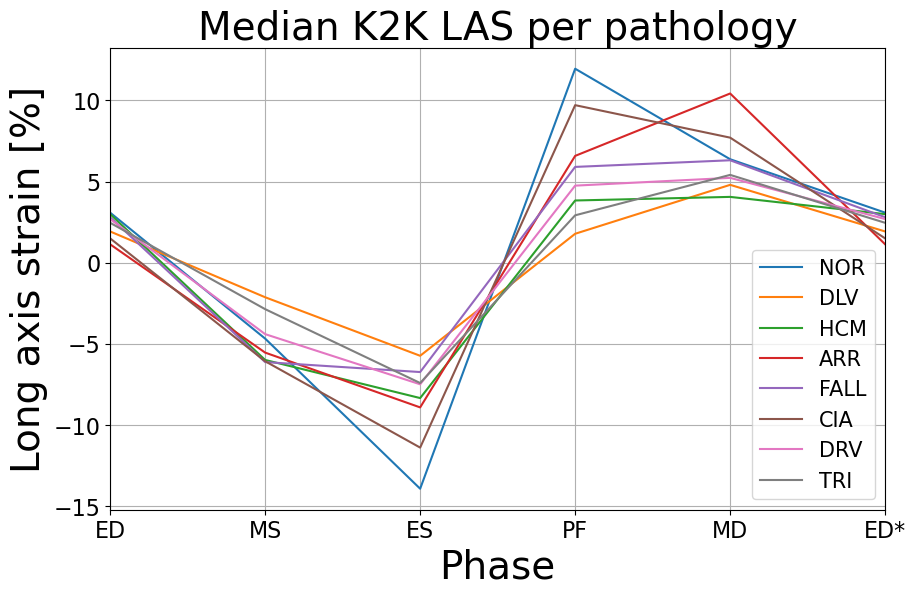

In [34]:
# Plot Median
plot_avg_curves(median_ed2k_array, median_k2k_array, median_ed2k_per_pathology, median_k2k_per_pathology, unique_pathologies, avg="Median")

In [38]:
# Create Dataframe with calculated LAS values per pathology
strain_df = pd.DataFrame({'Pathology': unique_pathologies,
                          'ED2MS': mean_ed2k_array[:, 1],
                          'ED2ES': mean_ed2k_array[:, 2],
                          'ED2PF': mean_ed2k_array[:, 3],
                          'ED2MD': mean_ed2k_array[:, 4],
                           # ... other ED2K columns
                          'MD2ED': mean_k2k_array[:, 0],
                          'ED2MS': mean_k2k_array[:, 1],
                          'MS2ES': mean_k2k_array[:, 2],
                          'ES2PF': mean_k2k_array[:, 3],
                          'PF2MD': mean_k2k_array[:, 4],
                           # ... other K2K columns
                         })
strain_df

,Pathology,ED2MS,ED2ES,ED2PF,ED2MD,MD2ED,MS2ES,ES2PF,PF2MD
0,NOR,-5.552993,-18.465170,-9.854705,-2.895916,3.027916,-13.626594,10.829171,8.085566
1,DLV,-2.072061,-9.184280,-6.578074,-1.829606,1.923048,-7.265706,3.019288,5.172231
2,HCM,-4.974266,-12.153189,-8.571142,-3.562165,3.778284,-7.498520,4.180405,5.595314
3,ARR,-5.523405,-13.623567,-9.540536,-1.091239,1.209080,-8.581680,4.968662,9.518110
4,FALL,-5.553611,-12.464844,-6.946830,-1.166685,1.312633,-7.292590,6.562453,6.242547
5,CIA,-6.057196,-17.223400,-7.832678,-1.194707,1.294533,-11.801261,11.796056,7.349753
6,DRV,-5.443869,-12.573776,-7.803407,-2.463965,2.583908,-7.440540,5.738747,6.096609
7,TRI,-3.674219,-11.793842,-8.059442,-2.847682,3.022994,-8.401223,4.389460,5.963082


# 3. Statistical analysis

## 3.1 Functions

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pathologies and phases
pathologies = unique_pathologies  # Example: ['NOR', 'HFpEF', 'HFmrEF', 'HFrEF']
phases = this_phases  # Example: ['ED', 'MS', 'ES', 'PF', 'MD']

# Function to compute median and IQR (interquartile range)
def compute_median_iqr(data, lower, upper):
    median = np.median(data, axis=0)
    mean = np.mean(data, axis=0)
    iqr_lower = np.percentile(data, lower, axis=0)
    iqr_upper = np.percentile(data, upper, axis=0)
    return median, mean, iqr_lower, iqr_upper



def plot_las_comparison(dataset_df, array, lower=25, upper=75, plot_median = True, plot_mean = True, plot_iqr = True, plot_against_NOR = True, layout = 'single_column'):
    # Compute median and IQR for NOR
    nor_indices = dataset_df['DISEASE'] == 'NOR'
    nor_las = array[nor_indices]
    nor_median, nor_mean, nor_iqr_lower, nor_iqr_upper = compute_median_iqr(nor_las, lower, upper)
    
    if plot_against_NOR:
        npathologies = len(unique_pathologies) - 1
    else:
        npathologies = len(unique_pathologies) 
        
    # Initialize plot and add healthy plot if not plot against each other
    if layout == 'single_column':
        ncols = 1
    elif layout == 'two_columns':
        ncols = 2
    else:
        ncols = max(1, len(pathologies) // 2)
    nrows = (npathologies + ncols - 1) // ncols 
    fig, axs = plt.subplots(nrows, ncols, figsize=( 14 ,  4 * nrows / ncols), sharex=True, squeeze=False)
    axs = axs.flatten()

    if not plot_against_NOR:
        ax = axs[0]
        ax.set_title(f" NOR - LAS")
        if plot_median: ax.plot(phases, nor_median, color='blue', label='NOR Median Strain')
        if plot_mean: ax.plot(phases, nor_mean, color='cyan', label='NOR Mean Strain')
        if plot_iqr: ax.fill_between(phases, nor_iqr_lower, nor_iqr_upper, color='blue', alpha=0.2, label='NOR IQR')
        ax.grid()
        ax.legend(loc='lower left', fontsize = 12/ncols)

    # Loop through pathologies, excluding NOR
    for i, pathology in enumerate(pathologies):
        if pathology == "NOR":
            continue  # Skip NOR vs NOR

        pathology_indices = dataset_df['DISEASE'] == pathology
        pathology_las= array[pathology_indices]

        # Compute median, mean and IQR for current pathology
        las_median, las_mean, las_iqr_lower, las_iqr_upper = compute_median_iqr(pathology_las, lower, upper)

        # Set current subplot
        if plot_against_NOR:
            ax = axs[i - 1 if pathology != "NOR" else i]
        else:
            ax = axs[i]
        # Set title and labels
        ax.set_title(f"{pathology} - LAS")
        ax.set_ylabel("Fast LV strain [%]")

        if plot_against_NOR:
            # Plot NOR data
            ax.set_title(f"{pathology} vs NOR - LAS")
            if plot_median: ax.plot(phases, nor_median, color='blue', label='NOR Median Strain')
            if plot_mean: ax.plot(phases, nor_mean, color='cyan', label='NOR Mean Strain')
            if plot_iqr: ax.fill_between(phases, nor_iqr_lower, nor_iqr_upper, color='blue', alpha=0.2, label='NOR IQR')

        # Plot current pathology data
        if plot_median: ax.plot(phases, las_median, color='red', label=f'{pathology} Median Strain')
        if plot_mean: ax.plot(phases, las_mean, color='deeppink', label=f'{pathology} Mean Strain')
        if plot_iqr: ax.fill_between(phases, las_iqr_lower, las_iqr_upper, color='red', alpha=0.2, label=f'{pathology} IQR')

        # Set Y-axis limits dynamically
        y_min = min(nor_iqr_lower.min(), las_iqr_lower.min()) - 1
        y_max = max(nor_iqr_upper.max(), las_iqr_upper.max()) + 1
        ax.set_ylim([y_min, y_max])
        ax.grid()

        # Position the legend to the left of the plot
        ax.legend(loc='lower left', fontsize = 12/ncols)
        
    # for j in range(i, len(axs)):
    #     axs[j].axis('off')
        
    # Set common X-axis limits and labels
    axs[-1].set_xlabel("Normalized Cardiac Cycle")
    plt.xlim([0, len(phases) - 1])
    plt.tight_layout()
    plt.show()

## 3.2 Interactive plot (LAS + landmark) for individual Patients 

In [41]:
@interact_manual
def interactive_plot_las(ed2k = True,
                         k2k = True,
                         patient = (0, len(ed2k_array),1),
                         plot_masks = True
                        ): 
    print(dataset_df.iloc[patient])
    all_points = results_df.iloc[patient]["point_coord"]
    long_axis_lens = results_df.iloc[patient]["long-axis L"]
    print( pred_df[phases].iloc[patient])
    k_masks = get_k_masks(masks_path[patient],  pred_df[phases].iloc[patient])
    print(results_df.iloc[patient])
    for msk in k_masks:
        msk = msk[0,...]
        lv_msk = (msk == 1).astype(np.uint8)
        myo_msk = (msk == 2).astype(np.uint8)
        
    ed2k_array, k2k_array = calculate_long_axis_strain(long_axis_lens, phases)
    if ed2k: plt.plot(phases, ed2k_array)
    if k2k: plt.plot(phases, k2k_array)

    # Set common X-axis limits and labels
    plt.xlabel("Normalized Cardiac Cycle")
    plt.ylabel('Long Axis Strain (%)')
    plt.xlim([0, len(phases) - 1])

    plt.tight_layout()
    plt.show()
    if plot_masks:
        for msk, points in zip(k_masks, all_points):
            msk = msk[0,...]
            # Plot the results
            plt.imshow(msk, cmap='gray')
            for mp in points['mitral_annulus_points']:
                plt.scatter(mp[1],  mp[0], color='red', label='MVIP',  marker='x')  # LVIP points in red
            plt.scatter(points['mitral_annulus_midpoint'][1],  points['mitral_annulus_midpoint'][0], color='lime', label='MVMP',  marker='x')  # MAP point in green
            plt.scatter(points['apex_point'][1], points['apex_point'][0], color='yellow', label='Apex Point at Endocardium',  marker='x')  # Apex point in blue
            plt.grid(visible=False)
            plt.title('LVIP, MAP, and Apex Point at Endocardium')
            plt.legend()
            plt.show()
    


interactive(children=(Checkbox(value=True, description='ed2k'), Checkbox(value=True, description='k2k'), IntSl…

## 3.2 Interactive plot LAS whole cohort
Different options for visualisation

In [40]:
# interactive plot the mean, median and iqr per pathology (along healhty patients) 
@interact_manual
def interactive_plot_las(ed2k = True,
                         lower =(0,50, 1),
                         upper=(50,100, 1),
                         plot_median = True, 
                         plot_mean = False,
                         plot_iqr = True, 
                         plot_against_NOR = True,
                         single_column_layout = True,
                         two_column_layout = False,
                         half_column_layout = False
                        ): 
    if ed2k:
        array = ed2k_array
    else:
        array = k2k_array
    if single_column_layout:
        layout = 'single_column'
    elif two_column_layout:
        layout = 'two_columns'
    else:
        layout = "half"
    plot_las_comparison(filtered_df, array, lower, upper, plot_median, plot_mean, plot_iqr, plot_against_NOR, layout=layout)

interactive(children=(Checkbox(value=True, description='ed2k'), IntSlider(value=25, description='lower', max=5…

## 3.3 Statistical significance if normal distribution

In [42]:
from scipy.stats import ttest_ind

# Apply multiple comparison correction (optional, e.g., Bonferroni)
from statsmodels.stats.multitest import multipletests

# Placeholder for storing results
stat_results_ed2k = {}
stat_results_k2k = {}

healthy_indices = filtered_df['DISEASE'] == 'NOR'  # Indices of healthy controls
healthy_ed2k = ed2k_array[healthy_indices]
healthy_k2k = k2k_array[healthy_indices]

# Iterate through each pathology
for pathology in unique_pathologies:
    
    pathology_indices = filtered_df['DISEASE'] == pathology
    pathology_ed2k = ed2k_array[pathology_indices]
    pathology_k2k = k2k_array[pathology_indices]
    
    if pathology == 'NOR':
        continue  # Skip comparison of healthy to itself
    # Perform t-tests
    ed2k_ttest = ttest_ind(healthy_ed2k, pathology_ed2k, axis=0, equal_var=False)
    k2k_ttest = ttest_ind(healthy_k2k, pathology_k2k, axis=0, equal_var=False)
    
    # Store results
    stat_results_ed2k[pathology] = ed2k_ttest.pvalue
    stat_results_k2k[pathology] = k2k_ttest.pvalue

# Flatten and correct p-values
all_pvalues = np.concatenate(list(stat_results_ed2k.values()) + list(stat_results_k2k.values()))
corrected_pvalues = multipletests(all_pvalues, method='bonferroni')[1]

# Replace original p-values with corrected ones
corrected_idx = 0
for pathology in stat_results_ed2k.keys():
    stat_results_ed2k[pathology] = corrected_pvalues[corrected_idx:corrected_idx+5]  # 5 phases
    corrected_idx += 5
    stat_results_k2k[pathology] = corrected_pvalues[corrected_idx:corrected_idx+5]  # 5 phases
    corrected_idx += 5

In [43]:
# Define a significance threshold
significance_threshold = 0.05

# Check for significant results for ED2K and K2K
print("Significant differences for ED2K:")
for pathology, pvalues in stat_results_ed2k.items():
    significant_phases = [phase for phase, p in zip(this_phases, pvalues) if p < significance_threshold]
    if significant_phases:
        print(f"{pathology}: Significant in phases {significant_phases} with p-values {[format(p, '.6f') for p in pvalues if p < significance_threshold]}")

print("\nSignificant differences for K2K:")
for pathology, pvalues in stat_results_k2k.items():
    significant_phases = [phase for phase, p in zip(this_phases, pvalues) if p < significance_threshold]
    if significant_phases:
        print(f"{pathology}: Significant in phases {significant_phases} with p-values {[format(p, '.6f')  for p in pvalues if p < significance_threshold]}")


Significant differences for ED2K:
DLV: Significant in phases ['MS', 'ES'] with p-values ['0.000304', '0.000000']
FALL: Significant in phases ['ES'] with p-values ['0.001709']
CIA: Significant in phases ['ES', 'PF'] with p-values ['0.000141', '0.039020']
DRV: Significant in phases ['ES'] with p-values ['0.035609']
TRI: Significant in phases ['ES'] with p-values ['0.029010']

Significant differences for K2K:
DLV: Significant in phases ['ES'] with p-values ['0.000065']
FALL: Significant in phases ['MS', 'ES', 'PF'] with p-values ['0.000304', '0.000379', '0.004412']
TRI: Significant in phases ['ES'] with p-values ['0.014975']


### 3.3.2 To Latex table

In [44]:
def results_to_latex_table(mean_array, array, stat_results, dataset_df, unique_pathologies, modus = "ED2K", skip_ed=True):
    # Placeholder for LaTeX table rows
    latex_rows = []
    # Transpose: Create rows for pathologies instead of phases
    for j, pathology in enumerate(unique_pathologies):
        row = [pathology]  # Start the row with the pathology name
        for i, phase in enumerate(phases):

            # Get mean and SD for each phase
            mean= mean_array[j, i]
            sd = np.std(array[dataset_df['DISEASE'] == pathology], axis=0)[i]

            value_str = f"{mean:.2f} ± {sd:.2f}"
            # Mark significant differences
            if pathology != "NOR":
                is_significant = stat_results[pathology][i] < significance_threshold
                if is_significant:
                    value_str += "*"

            row.append(value_str)
        latex_rows.append(row)
    latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|l|" + "c|" * len(phases) + "}\n"
    latex_table += "\\hline\n"
    latex_table += "Pathology & " + " & ".join(phases) + " \\\\\n"
    latex_table += "\\hline\n"

    for row in latex_rows:
        latex_table += " & ".join(row) + " \\\\\n"

    latex_table += "\\hline\n\\end{tabular}\n\\caption{Mean ± SD strain values for" + f"{modus}" + ", with significant differences marked (*).}\n\\end{table}"

    # Print the LaTeX table
    print(latex_table)

In [45]:
print("ED2K table:\n")
results_to_latex_table(mean_ed2k_array, ed2k_array, stat_results_ed2k, filtered_df, unique_pathologies)

print("\nK2K table:\n")
results_to_latex_table(mean_k2k_array, k2k_array, stat_results_k2k, filtered_df, unique_pathologies)

ED2K table:

\begin{table}[h!]
\centering
\begin{tabular}{|l|c|c|c|c|c|}
\hline
Pathology & ED & MS & ES & PF & MD \\
\hline
NOR & 0.00 ± 0.00 & -5.55 ± 3.03 & -18.47 ± 4.63 & -9.85 ± 5.65 & -2.90 ± 2.05 \\
DLV & 0.00 ± 0.00 & -2.07 ± 1.81* & -9.18 ± 4.55* & -6.58 ± 3.38 & -1.83 ± 2.36 \\
HCM & 0.00 ± 0.00 & -4.97 ± 3.73 & -12.15 ± 3.64 & -8.57 ± 3.62 & -3.56 ± 2.75 \\
ARR & 0.00 ± 0.00 & -5.52 ± 2.49 & -13.62 ± 6.75 & -9.54 ± 4.96 & -1.09 ± 3.26 \\
FALL & 0.00 ± 0.00 & -5.55 ± 3.57 & -12.46 ± 4.38* & -6.95 ± 2.46 & -1.17 ± 3.69 \\
CIA & 0.00 ± 0.00 & -6.06 ± 4.85 & -17.22 ± 5.20* & -7.83 ± 4.58* & -1.19 ± 2.88 \\
DRV & 0.00 ± 0.00 & -5.44 ± 5.14 & -12.57 ± 6.86* & -7.80 ± 5.75 & -2.46 ± 2.32 \\
TRI & 0.00 ± 0.00 & -3.67 ± 4.35 & -11.79 ± 5.56* & -8.06 ± 5.41 & -2.85 ± 2.88 \\
\hline
\end{tabular}
\caption{Mean ± SD strain values forED2K, with significant differences marked (*).}
\end{table}

K2K table:

\begin{table}[h!]
\centering
\begin{tabular}{|l|c|c|c|c|c|}
\hline
Pathology & ED 

## 3.4 Detailed statistical analysis
1. Check assumptions:
    - Shapiro-Wilk test checks normality for each group.
    - Levene's test checks homogeneity of variances across groups.

2. Pairwise Comparisons:
    - Parametric: Independent t-tests for pairwise comparisons.
    - Non-parametric: Mann-Whitney U tests if normality/variance assumptions are violated.

3. Groupwise Comparisons:
    - Parametric: One-way ANOVA.
    - Non-parametric: Kruskal-Wallis test.

4. Post-hoc Testing:
    - Tukey's HSD test is used for ANOVA significant results.
    - Dunns test

Output:

    Prints assumptions, pp-values, and statistical test results.
    Outputs post-hoc results when group differences are significant.

### 3.4.1 Functions for statistical analysis

In [46]:
from scipy.stats import ttest_ind, mannwhitneyu, f_oneway, kruskal, shapiro, levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import roc_curve, roc_auc_score

# Function to check normality and variance homogeneity
def check_assumptions(group_data, phases):
    normality_results = {phase: {} for phase in phases} 
    variance_results = {}
    
    # Check normality for each phase (Shapiro-Wilk test)
    for p_idx, phase in enumerate(phases):     
        for group, values in group_data.items():
            stat, p = shapiro(values[:, p_idx])  # Test normality for this phase
            normality_results[phase][group] = p >= 0.01  # True if data is normal
    
        # Homogeneity of variance (Levene's test) for each phase
        phase_data = [values[:, p_idx] for values in group_data.values()]
        stat, p = levene(*phase_data)  # Test variance homogeneity for this phase
        variance_results[phase] = p >= 0.05  # True if variances are homogeneous
    
    return normality_results, variance_results

# Perform pairwise t-tests or Mann-Whitney U tests
def pairwise_tests(data, phases, parametric=True):
    
    results = []
    groups = list(data.keys())
        
    for p_idx, phase in enumerate(phases): 
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                group1, group2 = groups[i], groups[j]
                if parametric:
                    stat, p_value = ttest_ind(data[group1][:, p_idx], data[group2][:, p_idx])
                else:
                    stat, p_value = mannwhitneyu(data[group1][:, p_idx ], data[group2][:, p_idx])
                results.append((group1, group2, phase, stat, p_value))
    return results


In [47]:
def rearrange_matrix(df, start_with=None):
    # Melt the matrix into a long format
    long_format = pd.melt(
        df.reset_index(),  # Reset index for proper melting
        id_vars="index", 
        var_name="Group_B", 
        value_name="p"
    )

    # Rename "index" to "Group_A"
    long_format.rename(columns={"index": "Group_A"}, inplace=True)

    # Filter out diagonal entries
    long_format = long_format[long_format["Group_A"] != long_format["Group_B"]]

    # Ensure unique pairs
    long_format["Pair"] = long_format.apply(
        lambda row: tuple(sorted([row["Group_A"], row["Group_B"]])), axis=1
    )
    long_format = long_format.drop_duplicates(subset="Pair")

    # Drop the helper "Pair" column
    long_format = long_format.drop(columns=["Pair"])

    # Add the "reject" column
    long_format["reject"] = long_format["p"] < 0.05

    # Reorder rows to prioritize comparisons with the starting group
    if start_with:
        long_format["priority"] = long_format.apply(
            lambda row: (0 if start_with in [row["Group_A"], row["Group_B"]] else 1,
                         sorted([row["Group_A"], row["Group_B"]])), 
            axis=1
        )
        long_format = long_format.sort_values(by="priority").drop(columns=["priority"])

    return long_format

In [48]:
# Perform ANOVA or Kruskal-Wallis tests
def groupwise_tests(data, phases, parametric=True):
    results = []
    groups = list(data.keys())
    
    for p_idx, phase in enumerate(phases):
        phase_data = [data[group][:, p_idx] for group in groups]
        
        # Remove groups with identical values
        filtered_data = [d for d in phase_data if len(np.unique(d)) > 1]
        
        if len(filtered_data) < 2:
            print(f"Skipping Phase {phase}: Insufficient variability among groups.")
            continue
        
        if parametric:
            stat, p_value = f_oneway(*filtered_data)
        else:
            stat, p_value = kruskal(*filtered_data)
        results.append((phase, stat, p_value))
    return results

# Perform post-hoc testing
def posthoc_tests(data, phases, parametric=True, dunns_adjust = 'holm'):
    """
    'bonferroni’ : one-step correction 
    ‘sidak’ : one-step correction 
    ‘holm-sidak’ : step-down method using Sidak adjustments 
    ‘holm’ : step-down method using Bonferroni adjustments 
    ‘simes-hochberg’ : step-up method (independent) 
    ‘hommel’ : closed method based on Simes tests (non-negative) 
    """
    results = {}
    if parametric:
        for p_idx, phase in enumerate(phases):   
            all_data = []
            labels = []
            for group, values in data.items():
                all_data.extend(values[:, p_idx])
                labels.extend([group] * len(values[:, p_idx]))
            tukey = pairwise_tukeyhsd(endog=np.array(all_data), groups=np.array(labels), alpha=0.05)
            results[phase] = tukey.summary()
            test = "Tukey's HSD"
            data_df = all_data
    else:
        from scikit_posthocs import posthoc_dunn
        rows = []
        for disease, values in data.items():
            for i, row in enumerate(values):
                rows.append({"disease": disease, **dict(zip(phases, row))})
        data_df = pd.DataFrame(rows)
        
        for phase in phases:
            results[phase] = rearrange_matrix(posthoc_dunn(data_df, val_col=phase, group_col="disease", p_adjust=dunns_adjust), start_with="NOR")
            test = "Dunn's test"
    return results, test, data_df

In [49]:
# ROC analysis
def roc_analysis(data, phases, control_group):
    roc_results = {}
    for p_idx, phase in enumerate(phases):
        y_true = []
        y_scores = []
        
        for group, values in data.items():
            y_true.extend([1 if group != control_group else 0] * len(values))
            y_scores.extend(values[:, p_idx])
        
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        auc = roc_auc_score(y_true, y_scores)
        roc_results[phase] = (fpr, tpr, auc)
        
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC={auc:.2f})')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Analysis for {phase}")
        plt.legend()
        plt.show()
    
    return roc_results

In [50]:
def main_analysis(data, phases, skip_ed=True):
    
    this_data = {disease: {} for disease in data.keys()} 
    if skip_ed:
        this_phases = phases[1:]
        for key in data.keys():
            this_data[key] = np.array([row[1:] for row in data[key]])
   
    else:
        this_phases = phases    
        this_data = data

    
    print("Step 1: Checking Assumptions")
    normality, variance = check_assumptions(this_data, this_phases)
    for phase in this_phases:
        print(f"\nPhase {phase}:")
        print("Normality Check:", normality[phase])
        print("Variance Homogeneity:", variance[phase])
    
    parametric = all(all(normality[phase].values()) for phase in this_phases) and all(variance.values())
    print("\nParametric Tests:", parametric)
    
    print("\nStep 2: Pairwise Comparisons")
    pairwise_results = pairwise_tests(this_data, this_phases, parametric=parametric)
    for result in pairwise_results:
        print(f"{result[0]} vs {result[1]} at {result[2]}: Stat = {result[3]:.6f}, p = {result[4]:.6f}")
    
    print("\nStep 3: Groupwise Comparisons (ANOVA/Kruskal-Wallis)")
    groupwise_results = groupwise_tests(this_data, this_phases, parametric=parametric)
    for result in groupwise_results:
        print(f"Phase {result[0]}: Stat = {result[1]:.8f}, p = {result[2]:.8f}")
    
    if any(r[2] < 0.05 for r in groupwise_results):
        print("\nStep 4: Post-hoc Testing")
        posthoc_results, test, data_df = posthoc_tests(this_data, this_phases, parametric=parametric)
        print(f"After: {test}")
        for phase, result in posthoc_results.items():
            print(f"\n-------------------------\nPost-hoc results for {phase}:\n", result)
            print(type(result))
            
    print("\nStep 5: ROC Analysis")
    control_group = "NOR"  # Specify control group
    roc_results = roc_analysis(this_data, this_phases, control_group)
    for phase, (fpr, tpr, auc) in roc_results.items():
        print(f"Phase {phase}: AUC = {auc:.3f}")
    
    return this_data, this_phases, normality, variance, parametric, pairwise_results, groupwise_results, posthoc_results, test, data_df

### 3.4.2 ED2K and K2K statistical analysis

Step 1: Checking Assumptions

Phase MS:
Normality Check: {'NOR': True, 'DLV': True, 'HCM': True, 'ARR': True, 'FALL': True, 'CIA': True, 'DRV': False, 'TRI': True}
Variance Homogeneity: True

Phase ES:
Normality Check: {'NOR': True, 'DLV': True, 'HCM': True, 'ARR': True, 'FALL': True, 'CIA': True, 'DRV': True, 'TRI': True}
Variance Homogeneity: True

Phase PF:
Normality Check: {'NOR': True, 'DLV': True, 'HCM': True, 'ARR': True, 'FALL': True, 'CIA': True, 'DRV': True, 'TRI': False}
Variance Homogeneity: True

Phase MD:
Normality Check: {'NOR': True, 'DLV': True, 'HCM': True, 'ARR': True, 'FALL': False, 'CIA': True, 'DRV': True, 'TRI': True}
Variance Homogeneity: True

Parametric Tests: False

Step 2: Pairwise Comparisons
NOR vs DLV at MS: Stat = 103.000000, p = 0.000004
NOR vs HCM at MS: Stat = 348.000000, p = 0.654202
NOR vs ARR at MS: Stat = 154.000000, p = 0.912947
NOR vs FALL at MS: Stat = 158.000000, p = 0.814783
NOR vs CIA at MS: Stat = 140.000000, p = 0.766673
NOR vs DRV at MS: 

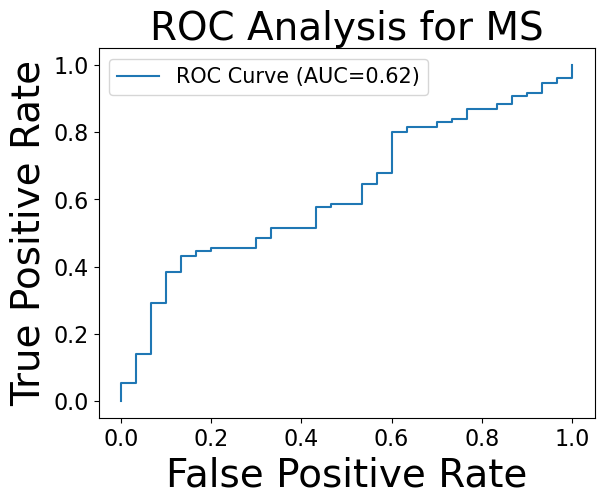

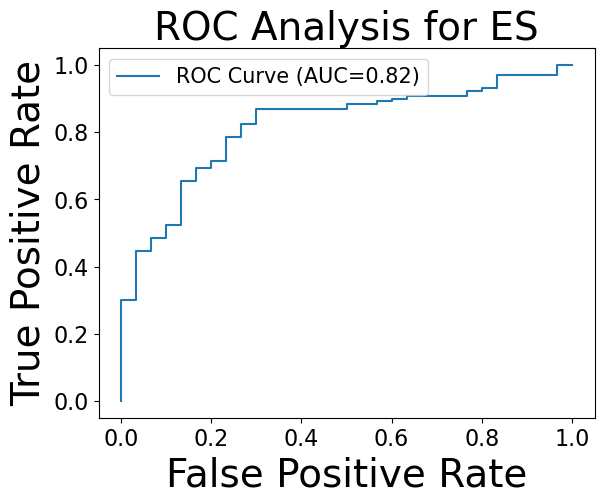

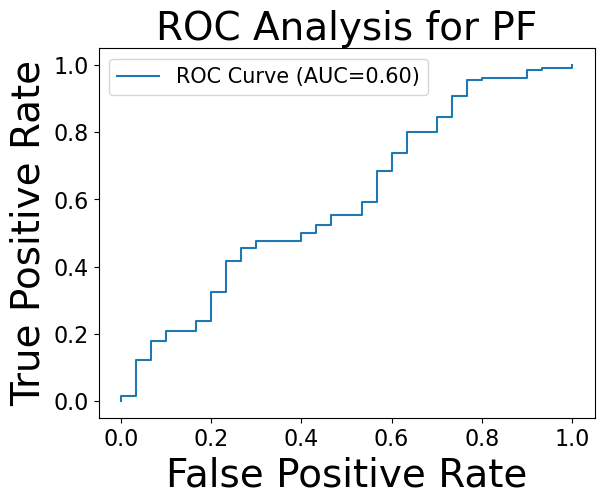

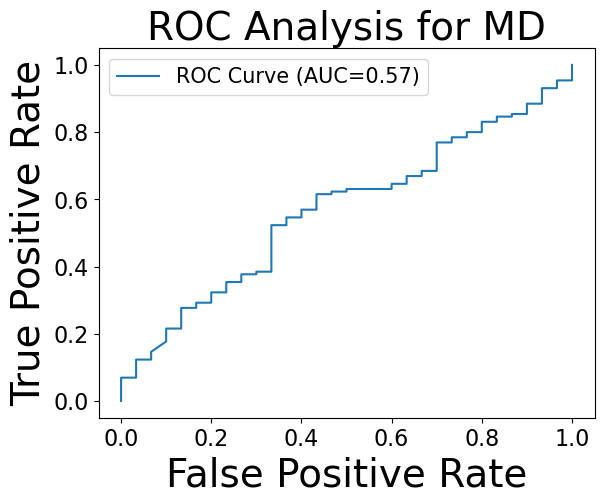

Phase MS: AUC = 0.622
Phase ES: AUC = 0.819
Phase PF: AUC = 0.597
Phase MD: AUC = 0.567


In [51]:
# Phases
phases = this_phases
# phases = ['ED', 'PEAK'] # Include this for ed 2 peak visualisation
# Loop through pathologies ed2k
data = {}
for i, pathology in enumerate(pathologies):
    pathology_indices = filtered_df['DISEASE'] == pathology
    pathology_ed2k = ed2k_array[pathology_indices]
    # pathology_ed2k = np.array(peak_dict['peak LAS'])[pathology_indices] # Include this for ed 2 peak visualisation
    data[pathology] = pathology_ed2k

# print(data)
# Run the analysis
ed2k_data, ed2k_phases, ed2k_normality, ed2k_variance, ed2k_parametric, ed2k_pairwise_results, ed2k_groupwise_results, ed2k_posthoc_results, ed2k_test, ed2k_data_df = main_analysis(data, phases, skip_ed =  True)

Step 1: Checking Assumptions

Phase ED:
Normality Check: {'NOR': True, 'DLV': True, 'HCM': True, 'ARR': True, 'FALL': False, 'CIA': True, 'DRV': True, 'TRI': True}
Variance Homogeneity: True

Phase MS:
Normality Check: {'NOR': True, 'DLV': True, 'HCM': True, 'ARR': True, 'FALL': True, 'CIA': True, 'DRV': False, 'TRI': True}
Variance Homogeneity: True

Phase ES:
Normality Check: {'NOR': True, 'DLV': True, 'HCM': True, 'ARR': True, 'FALL': True, 'CIA': True, 'DRV': True, 'TRI': True}
Variance Homogeneity: True

Phase PF:
Normality Check: {'NOR': True, 'DLV': False, 'HCM': True, 'ARR': True, 'FALL': True, 'CIA': True, 'DRV': True, 'TRI': False}
Variance Homogeneity: False

Phase MD:
Normality Check: {'NOR': False, 'DLV': True, 'HCM': True, 'ARR': True, 'FALL': True, 'CIA': True, 'DRV': True, 'TRI': False}
Variance Homogeneity: True

Parametric Tests: False

Step 2: Pairwise Comparisons
NOR vs DLV at ED: Stat = 490.500000, p = 0.051909
NOR vs HCM at ED: Stat = 321.500000, p = 0.370317
NOR 

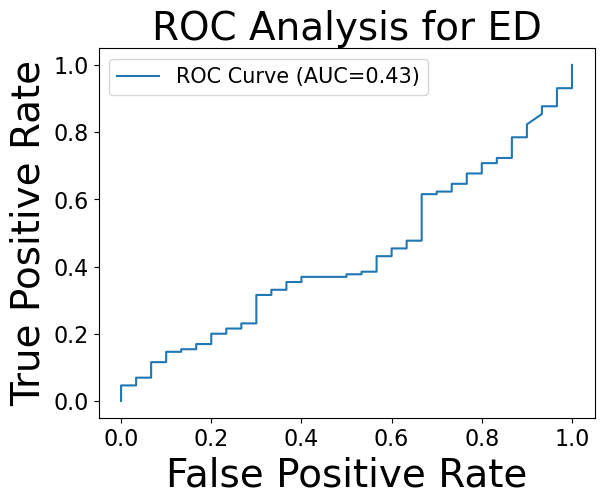

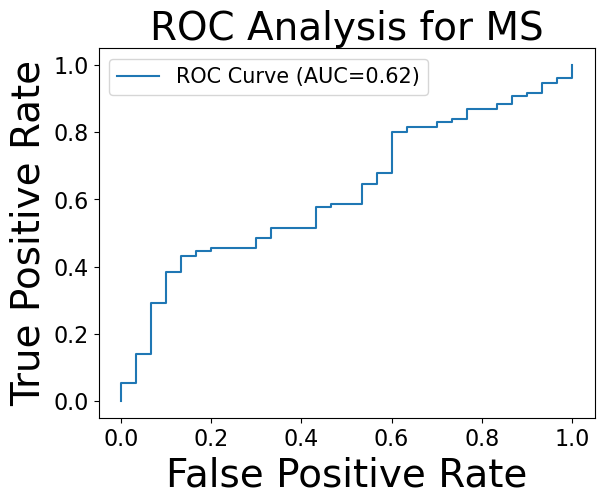

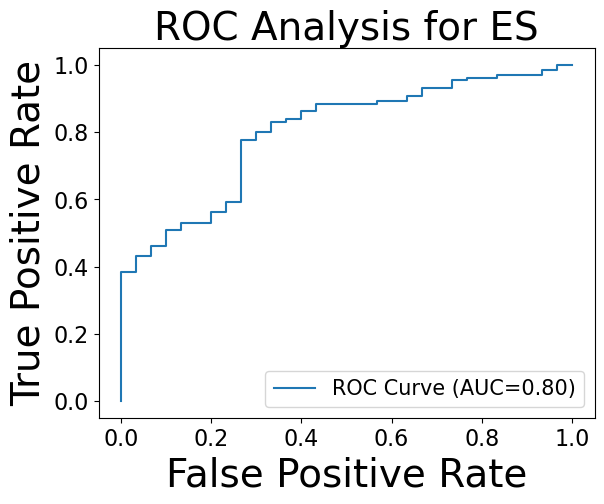

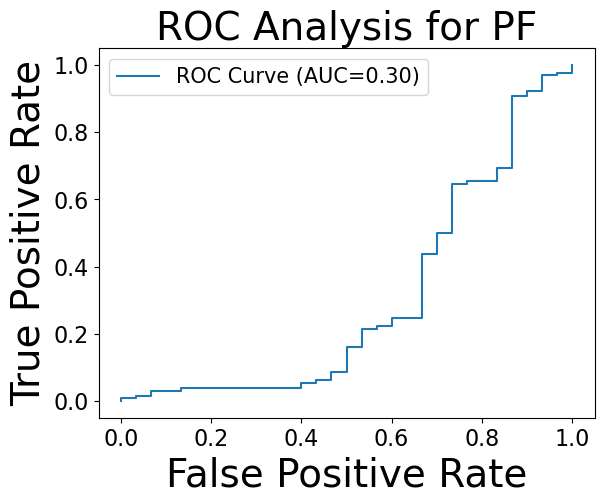

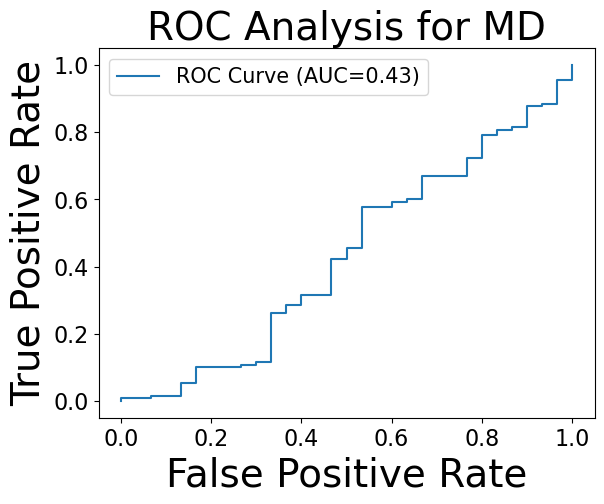

Phase ED: AUC = 0.433
Phase MS: AUC = 0.622
Phase ES: AUC = 0.799
Phase PF: AUC = 0.302
Phase MD: AUC = 0.429


In [52]:
# Loop through pathologies k2k
data_k2k = {}
for i, pathology in enumerate(pathologies):
    pathology_indices = filtered_df['DISEASE'] == pathology
    pathology_k2k = k2k_array[pathology_indices]
    data_k2k[pathology] = pathology_k2k

# Run the analysis
k2k_data, k2k_phases, k2k_normality, k2k_variance, k2k_parametric, k2k_pairwise_results, k2k_groupwise_results, k2k_posthoc_results, k2k_test, k2k_data_df  = main_analysis(data_k2k, phases, skip_ed=False)


### 3.4.3 Visualize detailed statistical analysis

In [53]:
import seaborn as sns
from statannotations.Annotator import Annotator

def boxplot_results_along_significance(data_df, posthoc_results, phases, significance_threshold=0.05, ED2K=True, first_disease="None"):
    diseases = np.unique(data_df.disease)
    plt.rcParams.update({
        'font.size': 14,       # Base font size
        'axes.titlesize': 26,  # Title font size
        'axes.labelsize': 28,  # Axis label font size
        'xtick.labelsize': 14, # X-tick label font size
        'ytick.labelsize': 14, # Y-tick label font size
        'legend.fontsize': 12  # Legend font size
    })
        
    # Reorder diseases to start with the selected first disease
    if first_disease and first_disease in diseases:
        diseases = np.array([first_disease] + sorted(d for d in diseases if d != first_disease))
    
    for entry, (idx, phase) in zip(posthoc_results.values(), enumerate(phases)):
        ax = sns.boxplot(data=data_df, x="disease", y=phase, order=diseases)

        # Filter pairs and p-values for significance
        significant_results = [
            (i[1]["Group_A"], i[1]["Group_B"], i[1]["p"])
            for i in entry.iterrows() if i[1]["p"] < significance_threshold
        ]
        pairs = [(res[0], res[1]) for res in significant_results]
        p_values = [res[2] for res in significant_results]

        # Proceed only if there are significant results
        if pairs:
            annotator = Annotator(
                ax, pairs, data=data_df, x="disease", y=phase, order=diseases
            )
            annotator.configure(text_format="star", loc="inside")
            annotator.set_pvalues_and_annotate(p_values)
        if ED2K:
            plt.ylabel("ED2" + phase)
        else:
            plt.ylabel(phases[idx-1] + "2" + phase)
        plt.xlabel('Group')
        plt.tight_layout()
        plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DLV vs. DRV: Custom statistical test, P_val:3.703e-02
ARR vs. DLV: Custom statistical test, P_val:4.755e-02
DLV vs. FALL: Custom statistical test, P_val:4.582e-02
NOR vs. DLV: Custom statistical test, P_val:7.500e-04
DLV vs. HCM: Custom statistical test, P_val:1.182e-02


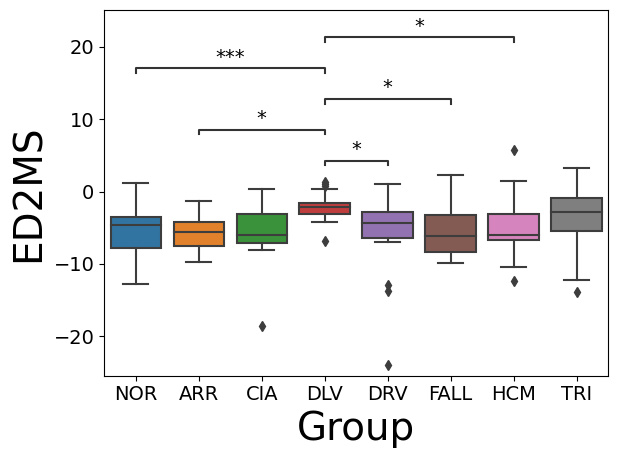

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CIA vs. DLV: Custom statistical test, P_val:6.288e-03
NOR vs. DLV: Custom statistical test, P_val:2.339e-08
NOR vs. DRV: Custom statistical test, P_val:5.407e-03
NOR vs. HCM: Custom statistical test, P_val:1.700e-03
NOR vs. TRI: Custom statistical test, P_val:3.424e-04


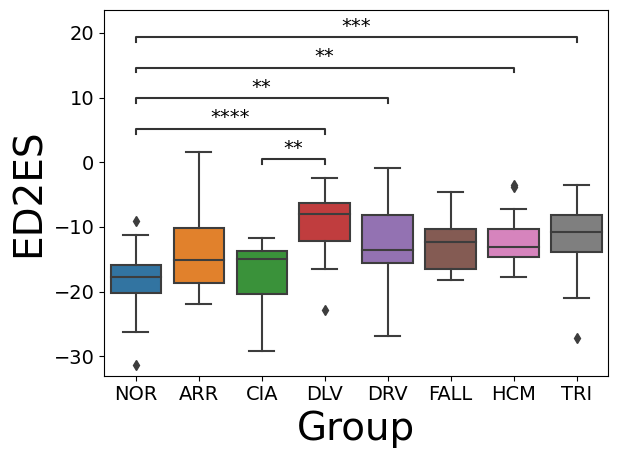

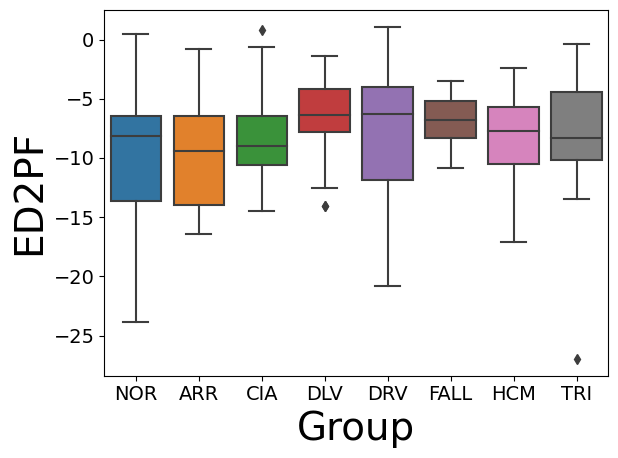

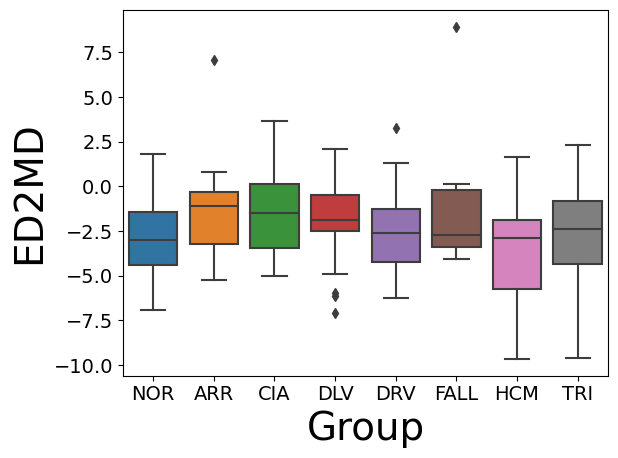

In [54]:
boxplot_results_along_significance(ed2k_data_df, ed2k_posthoc_results, ed2k_phases, first_disease="NOR")

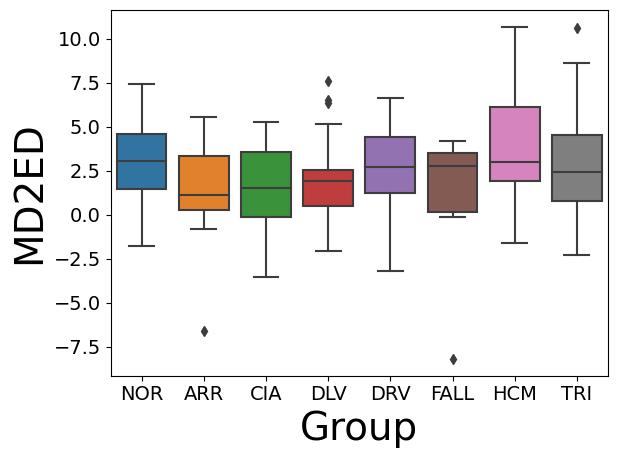

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DLV vs. DRV: Custom statistical test, P_val:3.703e-02
ARR vs. DLV: Custom statistical test, P_val:4.755e-02
DLV vs. FALL: Custom statistical test, P_val:4.582e-02
NOR vs. DLV: Custom statistical test, P_val:7.500e-04
DLV vs. HCM: Custom statistical test, P_val:1.182e-02


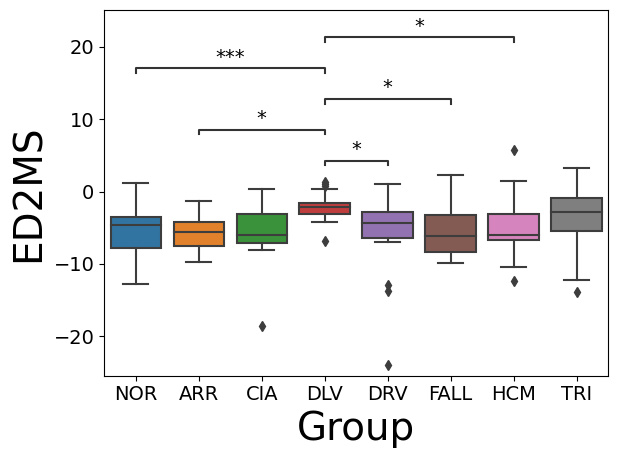

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NOR vs. DLV: Custom statistical test, P_val:1.214e-04
NOR vs. DRV: Custom statistical test, P_val:1.129e-03
NOR vs. FALL: Custom statistical test, P_val:2.666e-02
NOR vs. HCM: Custom statistical test, P_val:1.129e-03
NOR vs. TRI: Custom statistical test, P_val:5.486e-03


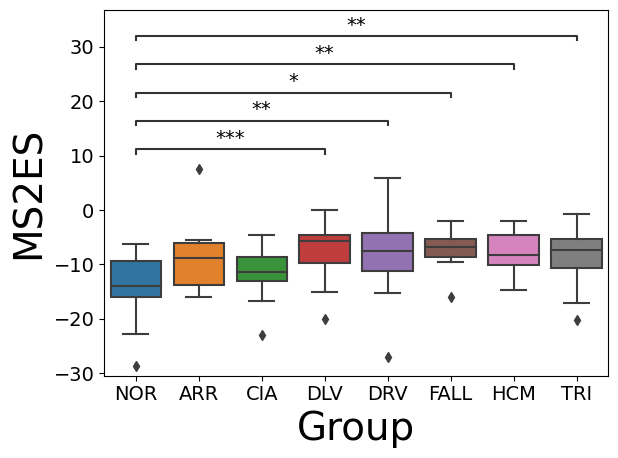

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NOR vs. DLV: Custom statistical test, P_val:6.043e-03


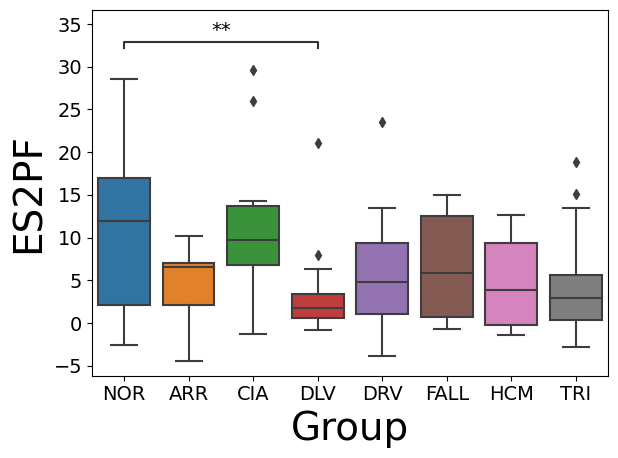

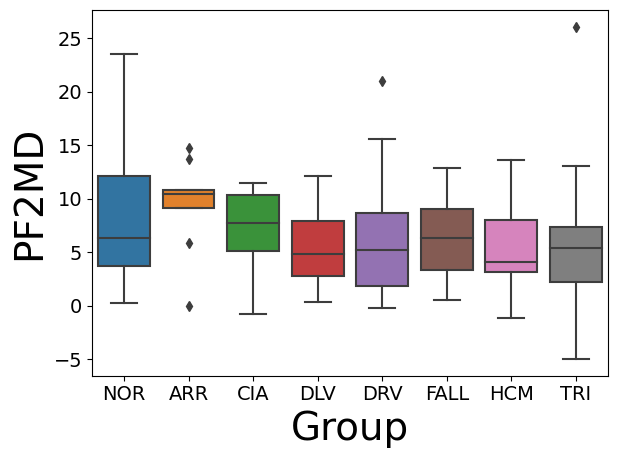

In [55]:
boxplot_results_along_significance(k2k_data_df, k2k_posthoc_results, k2k_phases, ED2K=False, first_disease="NOR")

### 3.4.4 Detect Outliers from IQR (Interquartile Range)

In [56]:
def extract_patient_id(filename):
    return filename.split('_')[0]

pid = "SUBJECT_CODE"
dataset_df[pid] = dataset_df[pid].astype(str)
results_df[pid] = results_df['patient'].apply(extract_patient_id).astype(str)
merged_df = pd.merge(dataset_df, results_df,on=pid, how='inner')
merged_df

,SUBJECT_CODE,DISEASE,VENDOR,SCANNER,FIELD,patient,ed2k,k2k,long-axis L,point_coord,gt
0,201,NOR,SIEMENS,SymphonyTim,1.5,201_LA_CINE_masks.nii.gz,"[0.0, -8.659609638470293, -14.920949392181655,...","[1.2234949551158498, -8.659609638470293, -6.85...","[77.41446893184762, 70.71067811865476, 65.8634...","[{'apex_point': (143, 177), 'mitral_annulus_po...",ED 24 MS 5 ES 9 PF 12 MD 22 N...
1,202,NOR,SIEMENS,SymphonyTim,1.5,202_LA_CINE_masks.nii.gz,"[0.0, -3.377802464424485, -17.877220313750787,...","[2.628414266928799, -3.377802464424485, -15.00...","[81.39410298049853, 78.64477096412705, 66.8430...","[{'apex_point': (181, 61), 'mitral_annulus_poi...",ED 24 MS 2 ES 9 PF 13 MD 22 N...
2,203,NOR,Philips Medical Systems,Achieva,1.5,203_LA_CINE_masks.nii.gz,"[0.0, -7.552597128587234, -20.61439818830755, ...","[3.0823701658123484, -7.552597128587234, -14.1...","[73.81734213584231, 68.24221567329127, 58.6003...","[{'apex_point': (161, 179), 'mitral_annulus_po...",ED 0 MS 3 ES 7 PF 10 MD 17 N...
3,204,NOR,Philips Medical Systems,Achieva,1.5,204_LA_CINE_masks.nii.gz,"[0.0, -9.538719125817885, -20.100655553446337,...","[5.428641512225034, -9.538719125817885, -11.67...","[75.76938695805846, 68.54195795277518, 60.5392...","[{'apex_point': (188, 76), 'mitral_annulus_poi...",ED 23 MS 4 ES 8 PF 13 MD 20 N...
4,205,NOR,Philips Medical Systems,Achieva,1.5,205_LA_CINE_masks.nii.gz,"[0.0, -4.382342182594283, -26.220516658340838,...","[6.8529392520772054, -4.382342182594283, -22.8...","[68.81860213634101, 65.80273550544841, 50.7740...","[{'apex_point': (185, 105), 'mitral_annulus_po...",ED 19 MS 2 ES 9 PF 12 MD 15 N...
...,...,...,...,...,...,...,...,...,...,...,...
155,356,TRI,SIEMENS,Symphony,1.5,356_LA_CINE_masks.nii.gz,"[0.0, -2.6858738679944048, -12.45941277714724,...","[4.348093371004787, -2.6858738679944048, -10.0...","[57.62811813689564, 56.08029957123981, 50.4479...","[{'apex_point': (192, 114), 'mitral_annulus_po...",ED 24 MS 4 ES 9 PF 14 MD 19 N...
156,357,TRI,SIEMENS,SymphonyTim,1.5,357_LA_CINE_masks.nii.gz,"[0.0, -4.285448254215335, -7.664318902729378, ...","[0.5004978014689099, -4.285448254215335, -3.53...","[65.7875368135941, 62.96824596572466, 60.74537...","[{'apex_point': (217, 86), 'mitral_annulus_poi...",ED 4 MS 9 ES 16 PF 20 MD 2 N...
157,358,TRI,SIEMENS,Symphony,1.5,358_LA_CINE_masks.nii.gz,"[0.0, -12.174973418064685, -27.23931248910011,...","[8.629801801712752, -12.174973418064685, -17.1...","[52.15361924162119, 45.803929962395145, 37.947...","[{'apex_point': (184, 66), 'mitral_annulus_poi...",ED 1 MS 5 ES 12 PF 16 MD 20 N...
158,359,TRI,SIEMENS,SymphonyTim,1.5,359_LA_CINE_masks.nii.gz,"[0.0, 3.192289676354454, -10.884223497622923, ...","[3.891604942826191, 3.192289676354454, -13.641...","[68.00735254367721, 70.178344238091, 60.605280...","[{'apex_point': (158, 94), 'mitral_annulus_poi...",ED 23 MS 3 ES 10 PF 16 MD 19 N...


In [57]:
import numpy as np

def detect_outliers_from_df(dataset_df, upper=75, lower=25):
    """
    Identify strong outliers based on the IQR method for each disease and phase.

    Parameters:
        dataset_df (DataFrame): DataFrame containing patient data with 'DISEASE' and 'ed2k' columns.
        upper (int): Upper percentile for IQR.
        lower (int): Lower percentile for IQR.

    Returns:
        dict: A dictionary with disease and phase as keys, and a list of outlier SUBJECT_CODEs as values.
    """
    outlier_dict = {}
    
    # Group by disease
    grouped = dataset_df.groupby('DISEASE')
    
    for disease, group_df in grouped:
        outlier_dict[disease] = {}
        # Extract phase values from 'ed2k' (assuming it's a list)
        phase_values = np.array(group_df['ed2k'].tolist())
        
        phases = ['ED2ED', 'ED2MS',' ED2ES', 'ED2PF', 'ED2MD']
        # Loop through each phase
        for phase_idx, phase in enumerate(phases):
            if phase == "ED2ED":
                continue
                
            phase_data = phase_values[:, phase_idx]
            phase_data = phase_data[np.isfinite(phase_data)].astype(float)
            if len(phase_data) == 0:
                continue
            q1 = np.percentile(phase_data, lower)
            q3 = np.percentile(phase_data, upper)
            iqr = q3 - q1
            
            # Define outlier thresholds
            lower_bound = q1 - 3 * iqr
            upper_bound = q3 + 3 * iqr
            
            
            # Identify outliers
            outlier_indices = np.where((phase_data < lower_bound) | (phase_data > upper_bound))[0]
            
            if len(outlier_indices) > 0:
                outlier_dict[disease][phase] = [group_df.iloc[ele]['SUBJECT_CODE'] for ele in outlier_indices.tolist()]
    return outlier_dict

outliers = detect_outliers_from_df(merged_df, upper=75, lower = 25)
# Print the results
for pathology, phase_outliers in outliers.items():
    print(f"Pathology: {pathology}")
    for phase, patient_indices in phase_outliers.items():
        if patient_indices:
            print(f"  Phase: {phase}, Outlier Indices: {patient_indices}")


Pathology: ARR
Pathology: CIA
Pathology: DLV
Pathology: DRV
  Phase: ED2MS, Outlier Indices: ['325']
Pathology: FALL
Pathology: HCM
Pathology: NOR
Pathology: TRI


# 4. Export Results

In [58]:
cmr_path_chooser = FileChooser(os.path.join(os.getcwd(),''), '')
display(cmr_path_chooser)

FileChooser(path='/mnt/ssd/sarah/git/cmr-phase2phase-las-analysis', filename='', title='', show_hidden=False, …

In [472]:
cmr_path = cmr_path_chooser.selected
img_path2 = get_file(os.path.join(cmr_path, 'lax/*CINE.nii.gz'))
dataset_info_path2 = get_file(os.path.join(cmr_path, 'dataset_information.csv'))

dataset_df2 = pd.read_csv(dataset_info_path2[0])
print(dataset_df2)
print(f"Number of images: {len(img_path2)}")

160
1
     SUBJECT_CODE DISEASE                   VENDOR      SCANNER  FIELD
0             201     NOR                  SIEMENS  SymphonyTim    1.5
1             202     NOR                  SIEMENS  SymphonyTim    1.5
2             203     NOR  Philips Medical Systems      Achieva    1.5
3             204     NOR  Philips Medical Systems      Achieva    1.5
4             205     NOR  Philips Medical Systems      Achieva    1.5
..            ...     ...                      ...          ...    ...
155           356     TRI                  SIEMENS     Symphony    1.5
156           357     TRI                  SIEMENS  SymphonyTim    1.5
157           358     TRI                  SIEMENS     Symphony    1.5
158           359     TRI                  SIEMENS  SymphonyTim    1.5
159           360     TRI                  SIEMENS  SymphonyTim    1.5

[160 rows x 5 columns]
Number of images: 160


In [28]:
def create_circular_mask(shape, center, value, radius=None):
    """Draw a filled circle (point) on the mask."""
    mask = np.zeros(shape, dtype=np.uint8)
    if radius is None:
        radius = round((shape[1]+shape[2])/400)
    # print(f"Point_position: {center}")
    # print(f"Shape: {shape}\nRadius: {radius}")
    cv2.circle(mask[0,...], (center[1].astype(np.uint16), center[0].astype(np.uint16)), int(radius), value, -1)  # -1 fills the circle
    
    return mask


def create_line_mask(shape, point1, point2, value, thickness=1):
    """Draw a line between two points with thickness."""
    mask = np.zeros(shape, dtype=np.uint8)[0,...]
    
    # print(f"Line: {(point1[1], point1[0]), (point2[1], point2[0])}")
    cv2.line(mask, (point1[1], point1[0]), (point2[1], point2[0]), value, int(thickness))
    return mask


In [29]:
from src.models.predict_phase_reg_model import save_sitk
def save_array_as_nifti(array, image, output_path):
    if array.ndim == 3:  # If (T, H, W), ensure (T, 1, H, W) format
        array = array[:, np.newaxis, :, :]
    # array = np.transpose(array, ( 1, 2, 3, 0))

    spacing = image.GetSpacing()
    spacing = list(reversed(spacing)) + [1.0, 1.0]
    new_images = [sitk.GetImageFromArray(t) for t in array]
    save_sitk(new_images, spacing, output_path)

In [30]:
from src.models.predict_phase_reg_model import write_sitk
time_steps_name = ["ED", "MS", "ES", "PF", "MD"]

def process_patient_nifti(nifti_path, patient_folder, time_steps, point_data):
    # Load NIfTI
    image = sitk.ReadImage(nifti_path)
    array = sitk.GetArrayFromImage(image)
    # Extract required timesteps
    selected_images = array[time_steps, ...]
    file_str = str(patient_folder.split("/")[-1]) + "_key_frame_CINE.nii.gz"
    save_array_as_nifti(selected_images, image, os.path.join(patient_folder, file_str))
    # Save new NIfTI
    new_image = sitk.GetImageFromArray(selected_images)
    
    # Generate mask
    mask = np.zeros_like(selected_images, dtype=np.uint8)


    for t, step in enumerate(time_steps):
        coords = point_data[t]
        if coords:
            mask[t] += create_circular_mask(mask[t].shape, coords['apex_point'], 2)
            mask[t] += create_circular_mask(mask[t].shape, coords['mitral_annulus_points'][0], 1)
            mask[t] += create_circular_mask(mask[t].shape, coords['mitral_annulus_points'][1], 1)
            mask[t] += create_circular_mask(mask[t].shape, coords['mitral_annulus_midpoint'], 3)
            mask[t] += create_line_mask(mask[t].shape, coords['apex_point'], coords['mitral_annulus_midpoint'], 4)
    # Save mask
    file_str = str(patient_folder.split("/")[-1]) + "_landmarks_CINE.nii.gz"
    save_array_as_nifti(mask, image, os.path.join(patient_folder, file_str))
    save_array_as_nifti(mask, image, os.path.join(patient_folder, file_str))
    
    # Generate PNG visualization
    fig, axes = plt.subplots(1, len(time_steps), figsize=(200, 80))

    for i, ax in enumerate(axes):
        ax.imshow(selected_images[i][0, ...], cmap='gray')

        # Masking lowest values to make them transparent
        masked_mask = np.ma.masked_where(mask[i][0, ...] == mask[i][0, ...].min(), mask[i][0, ...])

        ax.imshow(masked_mask, cmap='jet', alpha=0.5)
        ax.set_title(time_steps_name[i], fontsize=80)  # Set title above each image
        ax.axis('off')
    file_str = str(patient_folder.split("/")[-1]) + "_CMR_with_landmarks.png"
    plt.savefig(os.path.join(patient_folder, file_str), bbox_inches='tight')
    plt.close()

In [31]:
def export_files(nifti_list, merged_df, output_folder, focus_idx=[]):
    for idx, nifti_path in enumerate(nifti_list):
        if len(focus_idx) > 0 and idx not in focus_idx:
            continue
        patient_id = os.path.basename(nifti_path).split("/")[-1][:3]
        print(patient_id)
        patient_data = merged_df[merged_df['SUBJECT_CODE'] == patient_id]
        # print(patient_data)
        if patient_data.empty:
            continue
        
        patient_folder = os.path.join(output_folder, patient_id)
        os.makedirs(patient_folder, exist_ok=True)
        
        time_steps = patient_data.iloc[0]['gt'].values  # Extract required time points
        point_data = patient_data.iloc[0]['point_coord']  # Extract point annotations
        
        process_patient_nifti(nifti_path, patient_folder, time_steps, point_data)

In [501]:
focus_idx = [108]

In [502]:
nifti_files = img_path2
output_dir = os.path.join(cmr_path, "las")
print(len(nifti_files))
export_files(nifti_files, merged_df, output_dir, focus_idx=focus_idx)


160
309


# 5. Visualisations / Videos

In [6]:
# Select output folder
output_path_chooser = FileChooser(os.path.join(os.getcwd(),''), '')
display(output_path_chooser)

FileChooser(path='/mnt/ssd/sarah/git/cmr-LAX-phase-detection', filename='', title='', show_hidden=False, selec…

In [7]:
output_path = output_path_chooser.selected

In [26]:
def save_gif_from_landmarks_clean(all_images, landmark_mask, time_steps, output_path):
    import imageio
    from PIL import Image
    import matplotlib.pyplot as plt
    import io

    frames = []

    for i in range(len(time_steps)):
        fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

        # Plot image
        ax.imshow(all_images[i][0, ...], cmap='gray', interpolation='none')

        # Plot overlay (with no masking if preferred)
        masked_mask = np.ma.masked_where(landmark_mask[i][0, ...] == 0, landmark_mask[i][0, ...])
        ax.imshow(masked_mask, cmap='jet', alpha=0.6, interpolation='none')

        # Remove all borders, ticks, and titles
        ax.axis('off')

        # Save figure to memory buffer
        buf = io.BytesIO()
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # No padding
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
        plt.close(fig)
        buf.seek(0)

        # Convert to RGB image
        img = Image.open(buf).convert('RGB')
        frames.append(img)

    # Save the frames as a GIF
    frames[0].save(output_path, save_all=True, append_images=frames[1:], duration=200, loop=0)




In [65]:
def save_array_as_nifti(array, reference_image, output_path):
    """
    Save a NumPy array as a NIfTI file using a reference SimpleITK image for spacing, direction, and origin.
    """
    image = sitk.GetImageFromArray(array)
    # image.SetSpacing(reference_image.GetSpacing())
    # image.SetOrigin(reference_image.GetOrigin())
    # image.SetDirection(reference_image.GetDirection())
    sitk.WriteImage(image, output_path)

def save_LAS_patient_gif(msk_file, img_file, patient_folder, plot=False, save=False):
    patient_str = str(img_file.split("/")[-1][:-7])
    
    mask = sitk.ReadImage(msk_file)
    all_masks = sitk.GetArrayFromImage(mask)  # Shape: [T, Z, Y, X] (likely)
    time_steps = list(range(len(all_masks)))

    x_spacing, y_spacing, _, _ = mask.GetSpacing()

    
    msk_points = []
    long_axis_lens = []
    long_axis_lens_mm = []

    for idx_m, mask in enumerate(all_masks):
        mask = mask[0, ...]  # Check if needed — shape issue could arise here
        lv_mask = (mask == 1).astype(np.uint8)
        myo_mask = (mask == 2).astype(np.uint8)

        points = get_LV_landmarks_grow2(
            lv_mask, 
            myo_mask, 
            mask, 
            plot=plot, 
            epi_mid=True, 
            endo_mid=False
        )
        
        msk_points.append(points)

        if points is not None:
            long_axis_lens.append(measure_length(points['apex_point'], points['mitral_annulus_midpoint']))
            long_axis_lens_mm.append(measure_length_mm(points['apex_point'], points['mitral_annulus_midpoint'], x_spacing, y_spacing))
        else:
            print(f"No results for {fmsk_ile} (frame: {idx_m})")
            long_axis_lens.append(-1)

    information = {
        "patient": msk_file,
        "long-axis L": long_axis_lens,
        "long-axis L [mm]": long_axis_lens_mm,
        "point_coord": msk_points,
    }

    # Generate landmark mask
    landmark_mask = np.zeros_like(all_masks, dtype=np.uint8)
    for t, coords in enumerate(msk_points):
        if coords:
            landmark_mask[t] += create_circular_mask(landmark_mask[t].shape, coords['apex_point'], 3, radius=2)
            landmark_mask[t] += create_circular_mask(landmark_mask[t].shape, coords['mitral_annulus_points'][0], 1,  radius=2)
            landmark_mask[t] += create_circular_mask(landmark_mask[t].shape, coords['mitral_annulus_points'][1], 1, radius=2)
            landmark_mask[t] += create_circular_mask(landmark_mask[t].shape, coords['mitral_annulus_midpoint'], 2, radius=2)


    if save:
        
        image = sitk.ReadImage(img_file)
        all_images = sitk.GetArrayFromImage(image)  # Shape: [T, Z, Y, X] (likely)
        gif_out = os.path.join(patient_folder, patient_str + "_CMR_with_mask.gif")
        save_gif_from_landmarks_clean(all_images, all_masks, time_steps, gif_out)
    return information

In [76]:
test_idx = 2gt_df
msk_file = masks_path[test_idx]
img_file = img_path[test_idx]
info = save_LAS_patient_gif(msk_file, img_file, output_path, save=True)



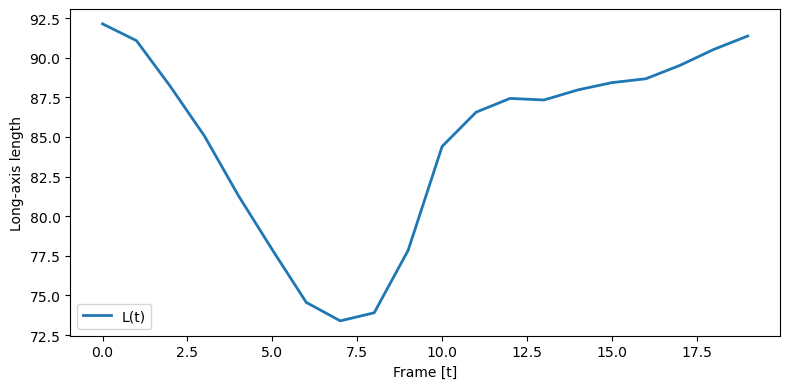

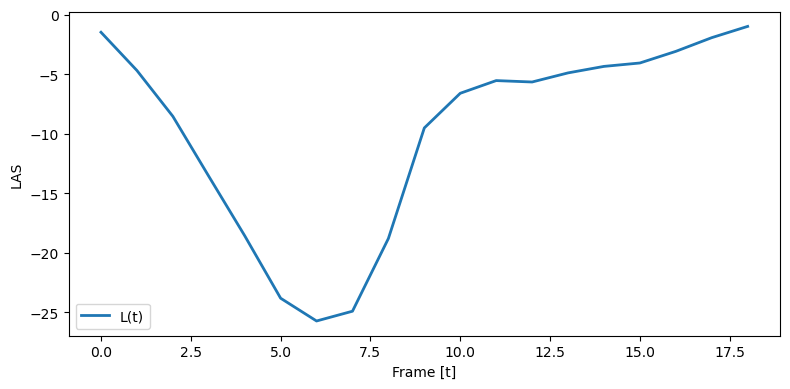

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def make_plot(l_vals, x, title="Long-axis length"):
    # Apply Gaussian smoothing
    sigma = 0.6  # Standard deviation of the Gaussian (controls smoothing strength)
    l_vals_smooth = gaussian_filter1d(l_vals, sigma=sigma)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x, l_vals_smooth, label='L(t)', linewidth=2)
    # plt.scatter(x, l_vals, color='red', s=20, label='Original data')
    plt.xlabel("Frame [t]")
    plt.ylabel(title)
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
l_vals1 = np.array(info["long-axis L [mm]"])
x1 = np.arange(len(l_vals1))  # Frame indices
make_plot(l_vals1, x1)

ed_las = info["long-axis L [mm]"][0]
las_vals = np.array([(ele-ed_las)*100/ele for ele in info["long-axis L [mm]"][1:]])
x2 = np.arange(len(las_vals))
make_plot(las_vals, x2, "LAS")

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from PIL import Image
import io

def generate_l_curve_gif(l_vals, output_path, sigma=0.6, duration_per_frame=200, y_label="Long-axis Length [mm]", curve_label="L(t)"):
    x = np.arange(len(l_vals))
    y_smooth = gaussian_filter1d(l_vals, sigma=sigma)

    frames = []

    for i in range(len(x)):
        fig, ax = plt.subplots(figsize=(6, 4))

        # Plot the smoothed curve
        ax.plot(x, y_smooth, color='blue', linewidth=2, label=curve_label)

        # Moving red dot
        ax.plot(x[i], y_smooth[i], 'ro', markersize=10)

        # No grid, clear axis formatting
        ax.set_xlabel("Frame")
        ax.set_ylabel(y_label)
        ax.set_xticks(x)  # All frame numbers shown
        ax.set_xlim([x[0], x[-1]])
        ax.set_ylim([min(y_smooth) - 2, max(y_smooth) + 2])
        ax.legend()
        ax.grid(False)
        plt.tight_layout()

        # Save to buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.1)
        plt.close(fig)
        buf.seek(0)
        frames.append(Image.open(buf).convert("RGB"))

    # Save as animated GIF
    frames[0].save(output_path, save_all=True, append_images=frames[1:], duration=duration_per_frame, loop=0)


In [74]:
l_vals = info["long-axis L [mm]"]
gif_path = output_path + "long_axis_curve.gif"
generate_l_curve_gif(l_vals, gif_path, sigma=0.6, duration_per_frame=200)

ed_las = info["long-axis L [mm]"][0]
las_vals = np.array([(ele-ed_las)*100/ele for ele in info["long-axis L [mm]"][1:]])
gif_path = output_path + "las_curve.gif"
generate_l_curve_gif(las_vals, gif_path, sigma=0.6, duration_per_frame=200, y_label="Long-axis strain (LAS) [%]", curve_label="LAS(t)")

In [85]:
gt_df

,ED,MS,ES,PF,MD,patient
0,24,3,9,12,21,0_201_LA_CINE.nii.gz\n
1,0,4,9,13,22,0_202_LA_CINE.nii.gz\n
2,0,4,8,10,17,0_203_LA_CINE.nii.gz\n
3,0,4,9,12,20,0_204_LA_CINE.nii.gz\n
4,0,5,8,11,16,0_205_LA_CINE.nii.gz\n
...,...,...,...,...,...,...
155,24,3,9,14,21,0_356_LA_CINE.nii.gz\n
156,4,6,16,21,0,0_357_LA_CINE.nii.gz\n
157,1,2,10,16,20,0_358_LA_CINE.nii.gz\n
158,24,3,11,15,19,0_359_LA_CINE.nii.gz\n


In [203]:
peak_las_per_patient = []
patient_ids = []
for enum, (patient_msk, patient_img) in enumerate(zip(masks_path, img_path)):
    if any([str(x) in patient_img for x in exclude_patients]):
        print(f"Skip patient_file: {patient_img}")
        continue
    info = save_LAS_patient_gif(patient_msk, patient_img, output_path, plot=False)
    idx = patient_msk.split('/')[-1][:3]
    ed_las = info["long-axis L [mm]"][gt_df.loc[enum]['ED']]
    las_vals = np.array([(ele-ed_las)*100/ele for ele in info["long-axis L [mm]"][1:]])
    peak_las_per_patient.append([0, min(las_vals)])
    patient_ids.append(idx)
    
peak_dict = {'patient ID': patient_ids,
             'peak LAS': peak_las_per_patient}

# peak_dict

Skip patient_file: /mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/lax/211_LA_CINE.nii.gz
Skip patient_file: /mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/lax/213_LA_CINE.nii.gz
Skip patient_file: /mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/lax/229_LA_CINE.nii.gz
Skip patient_file: /mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/lax/233_LA_CINE.nii.gz
Skip patient_file: /mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/lax/237_LA_CINE.nii.gz
Skip patient_file: /mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/lax/240_LA_CINE.nii.gz
Skip patient_file: /mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/lax/244_LA_CINE.nii.gz
Skip patient_file: /mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/lax/249_LA_CINE.nii.gz
Skip patient_file: /mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/lax/259_LA_CINE.nii.gz
Skip patient_file: /mnt/ssd/sarah/data/mnm2/imported_LAX_2D_split/inference/lax/272_LA_CINE.nii.gz
Skip patie